# Analyse de données - Partie 2

## environnement

### librairies

In [102]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno
from IPython.core.display import HTML
# from dataprep.eda import plot
from dataprep.eda import plot_correlation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import multidict as multidict
from scipy.stats import shapiro, normaltest, bartlett, boxcox
import re

In [103]:
# ceci est une reglagle permettant de voir l'intégralité des lignes et des colonnes des dataframes
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

### importation des données

Chargons les dataset que nous avons déjà commencé à nettoyer

In [104]:
data = pd.read_csv("./df_cleaned.csv", low_memory=False, index_col=[0])
df_clean = data

### Constantes

In [105]:
ls_nutrigrade_order = ["a", "b", "c", "d", "e"]
palette_nutrigrade = ["#038141", "#85BB2F", "#FECB02", "#EE8100", "#E63E11", "#353535"]
ls_nutri_quali = [
    "ingredients_text",
    "allergens",
    "traces",
    "additives",
    "ingredients_from_palm_oil_n",
    "nutrition_grade_fr"
]
ls_nutri_quanti = [
    "fat_100g",
    "carbohydrates_100g",
    "energy_100g",
    "saturated-fat_100g",
    "sugars_100g",
    "fiber_100g",
    "salt_100g",
    "proteins_100g",
    "nutrition-score-fr_100g",
    "fruits-vegetables-nuts_100g",
    "vitamin-d_100g",
    "vitamin-c_100g",
    "iron_100g",
]
ls_logistic = [
    "product_name",
    "brands",
    "countries_fr",
    "pnns_groups_1"
]

### Librairie de fonctions

Je vais stocker ici les fonctions que j'ai définies, afin de pouvoir les réutiliser par la suite

In [106]:
def get_missing_val_rates(df) -> pd.DataFrame : 
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                    'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True, ascending = False)
    return missing_value_df

def keep_only_french_products(df):
    countries = df["countries_fr"].unique().tolist()
    countries = ['missing' if x is np.nan else x for x in countries]
    fr_countries = [i for i in countries if "rance" in i]
    return df[df["countries_fr"].isin(fr_countries)]

def get_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - (1.5*IQR)
    lim_sup = Q3 + (1.5*IQR)
    return df[(df[column]<lim_inf) | (df[column]>lim_sup)]

def replace_outliers_with_nan(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - (1.5*IQR)
    lim_sup = Q3 + (1.5*IQR)
    df[column][df[column] < lim_inf] = None
    df[column][df[column] > lim_sup] = None

def limit_col(df, col, inf, sup):
    df[col][df[col]<inf] = None
    df[col][df[col]>sup] = None

def get_outoflimit(df, col, inf, sup):
    return df[(df[col]<inf) | (df[col]>sup)]
    
def clean_col(df, column):
    df_subset = df.loc[df[column].notna()]
    df_subset = rm_outliers(df_subset, column)
    return df_subset

def get_most_frequent(df, col, n)->list:
    return df[col].value_counts()[:n].index.tolist()

def num_stats(df, column):
    nb_unique = df[column].nunique()
    nb_missing = df[column].isna().sum()
    missing_percent = (nb_missing / len(df[column])) *100
    minimum = df[column].min()
    maximum = df[column].max()
    percentile_5 = df[column].quantile(.05)
    Q1 = df[column].quantile(.25)
    median = df[column].median()
    Q3 = df[column].quantile(.75)
    percentile_95 = df[column].quantile(.95)
    range = maximum - minimum
    IQR = Q3 - Q1
    mean = df[column].mean()
    std = df[column].std()
    variance = df[column].var()
    sum = df[column].sum()
    kurtosis = df[column].kurt()
    cv = (std/mean)*100
    df_return = pd.DataFrame({
        "nb_unique" : [nb_unique],
        "nb_manquants" : [nb_missing],
        "% manquant" : [missing_percent],
        "minimum" : [minimum],
        "quantile 5%" : [percentile_5],
        "Q1" : [Q1],
        "mediane" : [median],
        "Q3" : [Q3],
        "quantile 95%" : [percentile_95],
        "maximum" : [maximum],
        "amplitude" :  [range],
        "IQR" : [IQR],
        "moyenne" : [mean],
        "écart-type" : [std],
        "variance" : [variance],
        "somme" : [sum],
        "kurtosis" : [kurtosis],
        "coefficient de variation" : [cv]
    })
    return df_return

def cat_stats(df, column):
    nb_unique = df[column].nunique()
    nb_missing = df[column].isna().sum()
    missing_percent = (nb_missing / len(df[column])) *100
    most_frequent = df[column].value_counts().idxmax()
    most_frequent_rate = df[column].value_counts(normalize=True).tolist()[0]*100
    df_return = pd.DataFrame({
        "nb_unique" : [nb_unique],
        "nb_manquants" : [nb_missing],
        "% manquant" : [missing_percent],
        "valeur la plus fréquente" : [most_frequent],
        "% valeur la plus fréquente" : [most_frequent_rate]
    })
    return df_return

def stats(df, column):
    if(df[column].dtype=="object"):
        df_return = cat_stats(df, column)
    else:
        df_return = num_stats(df, column)
    return df_return

def bar_top(df, column, top):
    df_plot = df.copy()
    df_plot.dropna(subset=[column], inplace=True)
    ax = sns.countplot(y=df_plot[column], 
                       order=df_plot[column].value_counts().iloc[:top].index, 
                       palette='rocket')
    ax.tick_params(axis='y', length=0)
    fig = plt.gcf()
    fig.suptitle("Top {} des {} valeurs de {}".format(top, df_plot[column].nunique(), column))
    plt.tight_layout()
    fig.set_size_inches(10,10)
    plt.show()
    return

def wc(df, col, sep=" "):
    mask = np.array(Image.open('./apple.jpg'))
    pattern = re.compile('[\W_]+')
    words = []
    for string in df[col]:
        string = pattern.sub('', str(string)) # enlève tous les caractères que l'on ne veut pas
        ls_words= str(string).split(sep)
        for w in ls_words:
            if (w!=' ')and (w!='nan'):
                words.append(w)
    cnt=Counter(words)
    wordcloud = WordCloud(width=1080, height=920, mask=mask).fit_words(cnt)
    plt.figure(figsize=(25,15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.show()
    return

def most_common_word(labels, sep=","):
    words=[]
    for lab in labels:
        words+=str(lab).split(sep)
    count=Counter(words)
    for word in count.most_common(100):
        print(word)

def fillrate_pie(df):
    l=4
    i=0
    j=0
    str_missing = "nombre de valeurs manquantes"
    str_nb_val = "nombre de valeurs"
    str_fill_rate = "taux de remplissage"
    str_real_val = "valeurs fournies"
    t=pd.DataFrame(index=[str_missing, 
                          str_nb_val,
                          str_fill_rate], 
                   columns=df.columns )
    for col in df.columns:
        nb_nan=df[col].isnull().sum()
        t.loc[str_missing,col]=nb_nan              
        t.loc[str_nb_val, col]= df.shape[0]-nb_nan 
        t.loc[str_fill_rate, col]=(df.shape[0]-nb_nan)/(df.shape[0]*1.0)

    f, ax = plt.subplots((df.shape[1]//5)+1, 
                         5, 
                         figsize=(l*5, l*(df.shape[1]//5)))
    f.subplots_adjust(left=0, 
                      right=0.9, 
                      top= 0.95, 
                      bottom= 0., 
                      wspace=0.9, 
                      hspace=0.9)
    f.tight_layout(rect=(0, 0, 0.95,0.95 ),
                   h_pad=0.5, 
                   w_pad=0.5)
    for col in df.columns:
        if i < 5:
            ax[j,i].pie(t.loc[[str_missing, str_nb_val], col], 
                            autopct='%0.1f',
                       colors=["red", "green"])
            ax[j,i].set_title(col)
            i+=1
        else:
            i=0
            j+=1
            ax[j,i].pie(t.loc[[str_missing, str_nb_val], col], 
                            autopct='%0.1f',
                       colors=["red", "green"])
            ax[j,i].set_title(col)
            i+=1
    f.legend(labels=[str_missing, 
                     str_real_val], 
             fontsize=15) 
    f.suptitle("ratio : {} / {}".format(str_real_val, 
                                                    str_missing), 
               fontsize=40, 
               fontweight=30)
    return

def scatter_one_to_many(df, ycol, xcols_list, title):
    ds=df.copy()
    x=pd.DataFrame(ds[ycol], 
                   columns=[ycol])
    fig=plt.figure(figsize=(30,15))
    plt.style.use("ggplot")
    plt.title(title)
    for col in xcols_list:
        plt.plot(ds[col], x, 'o',label=col)
    plt.ylabel(ycol)
    plt.plot([0, 100], [0, 3765.6], linewidth=5, linestyle='-', color='pink')# 9 Kcal = 37.656 kJ
    plt.plot([0, 100], [0, 1673.6], linewidth=7, color= 'blue', linestyle='-')# 4 Kcal = 1973.6 kJ
    plt.legend(loc='upper left', prop={'size':32})
    ax = plt.gca()
    # ax.set_xlim([0, 100])
    # ax.set_ylim([0, 0.03])
    return

def hist_distrib(df, column):
    df_plot = df.copy()
    df_plot.dropna(subset=[column], inplace=True)
    ax = sns.distplot(df_plot, 
                      x=df_plot[column])
    # ax.tick_params(axis='y', length=0)
    fig = plt.gcf()
    fig.suptitle("Distribution de {}".format(column))
    plt.tight_layout()
    fig.set_size_inches(10,10)
    plt.show()
    return

def plot(df, col):
    display(stats(df, col))
    if(df[col].dtype=="object"):
        bar_top(df, col, 10)
        wc(df, col)
    else:
        hist_distrib(df, col)
    return

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            fig.set_size_inches(15,15)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(15,15))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            
            fig.set_size_inches(15,15)

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    fig = plt.gcf()
    fig.set_size_inches(15,15)
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()
    return

def impute_KNN(df, ls):
    df_KNN = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(df.filter(regex='_100g')),
                           columns = df.filter(regex='_100g').columns)
    df = pd.concat([df[ls].reset_index(drop=True), 
                    df_KNN.reset_index(drop = True)], 
                   axis=1)
    return(df)

## Analyse multivariée

### Corrélation des variables

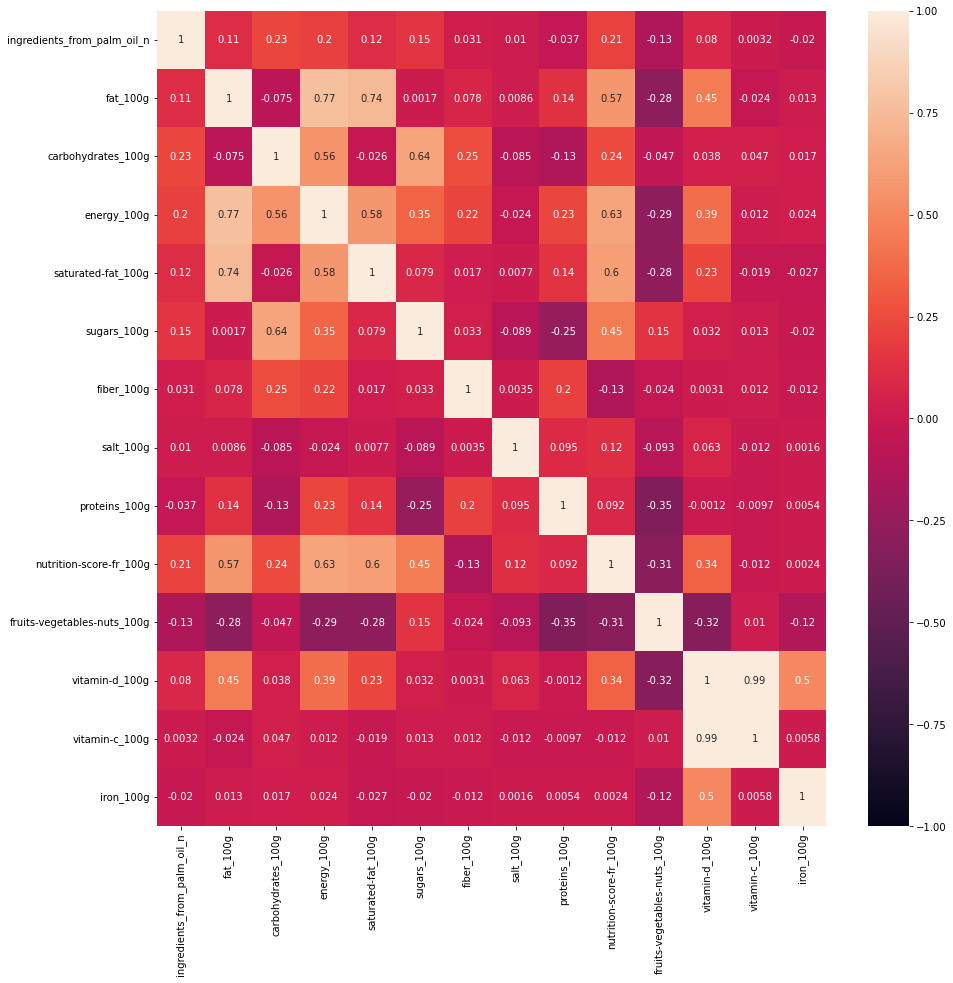

In [107]:
ax=sns.heatmap(df_clean.corr(), 
               xticklabels=True, 
               yticklabels=True, 
               annot=True,
               vmin=-1, 
               vmax=1)
fig = plt.gcf()
fig.set_size_inches(15,15)

### Pairplot des variables quantitatives

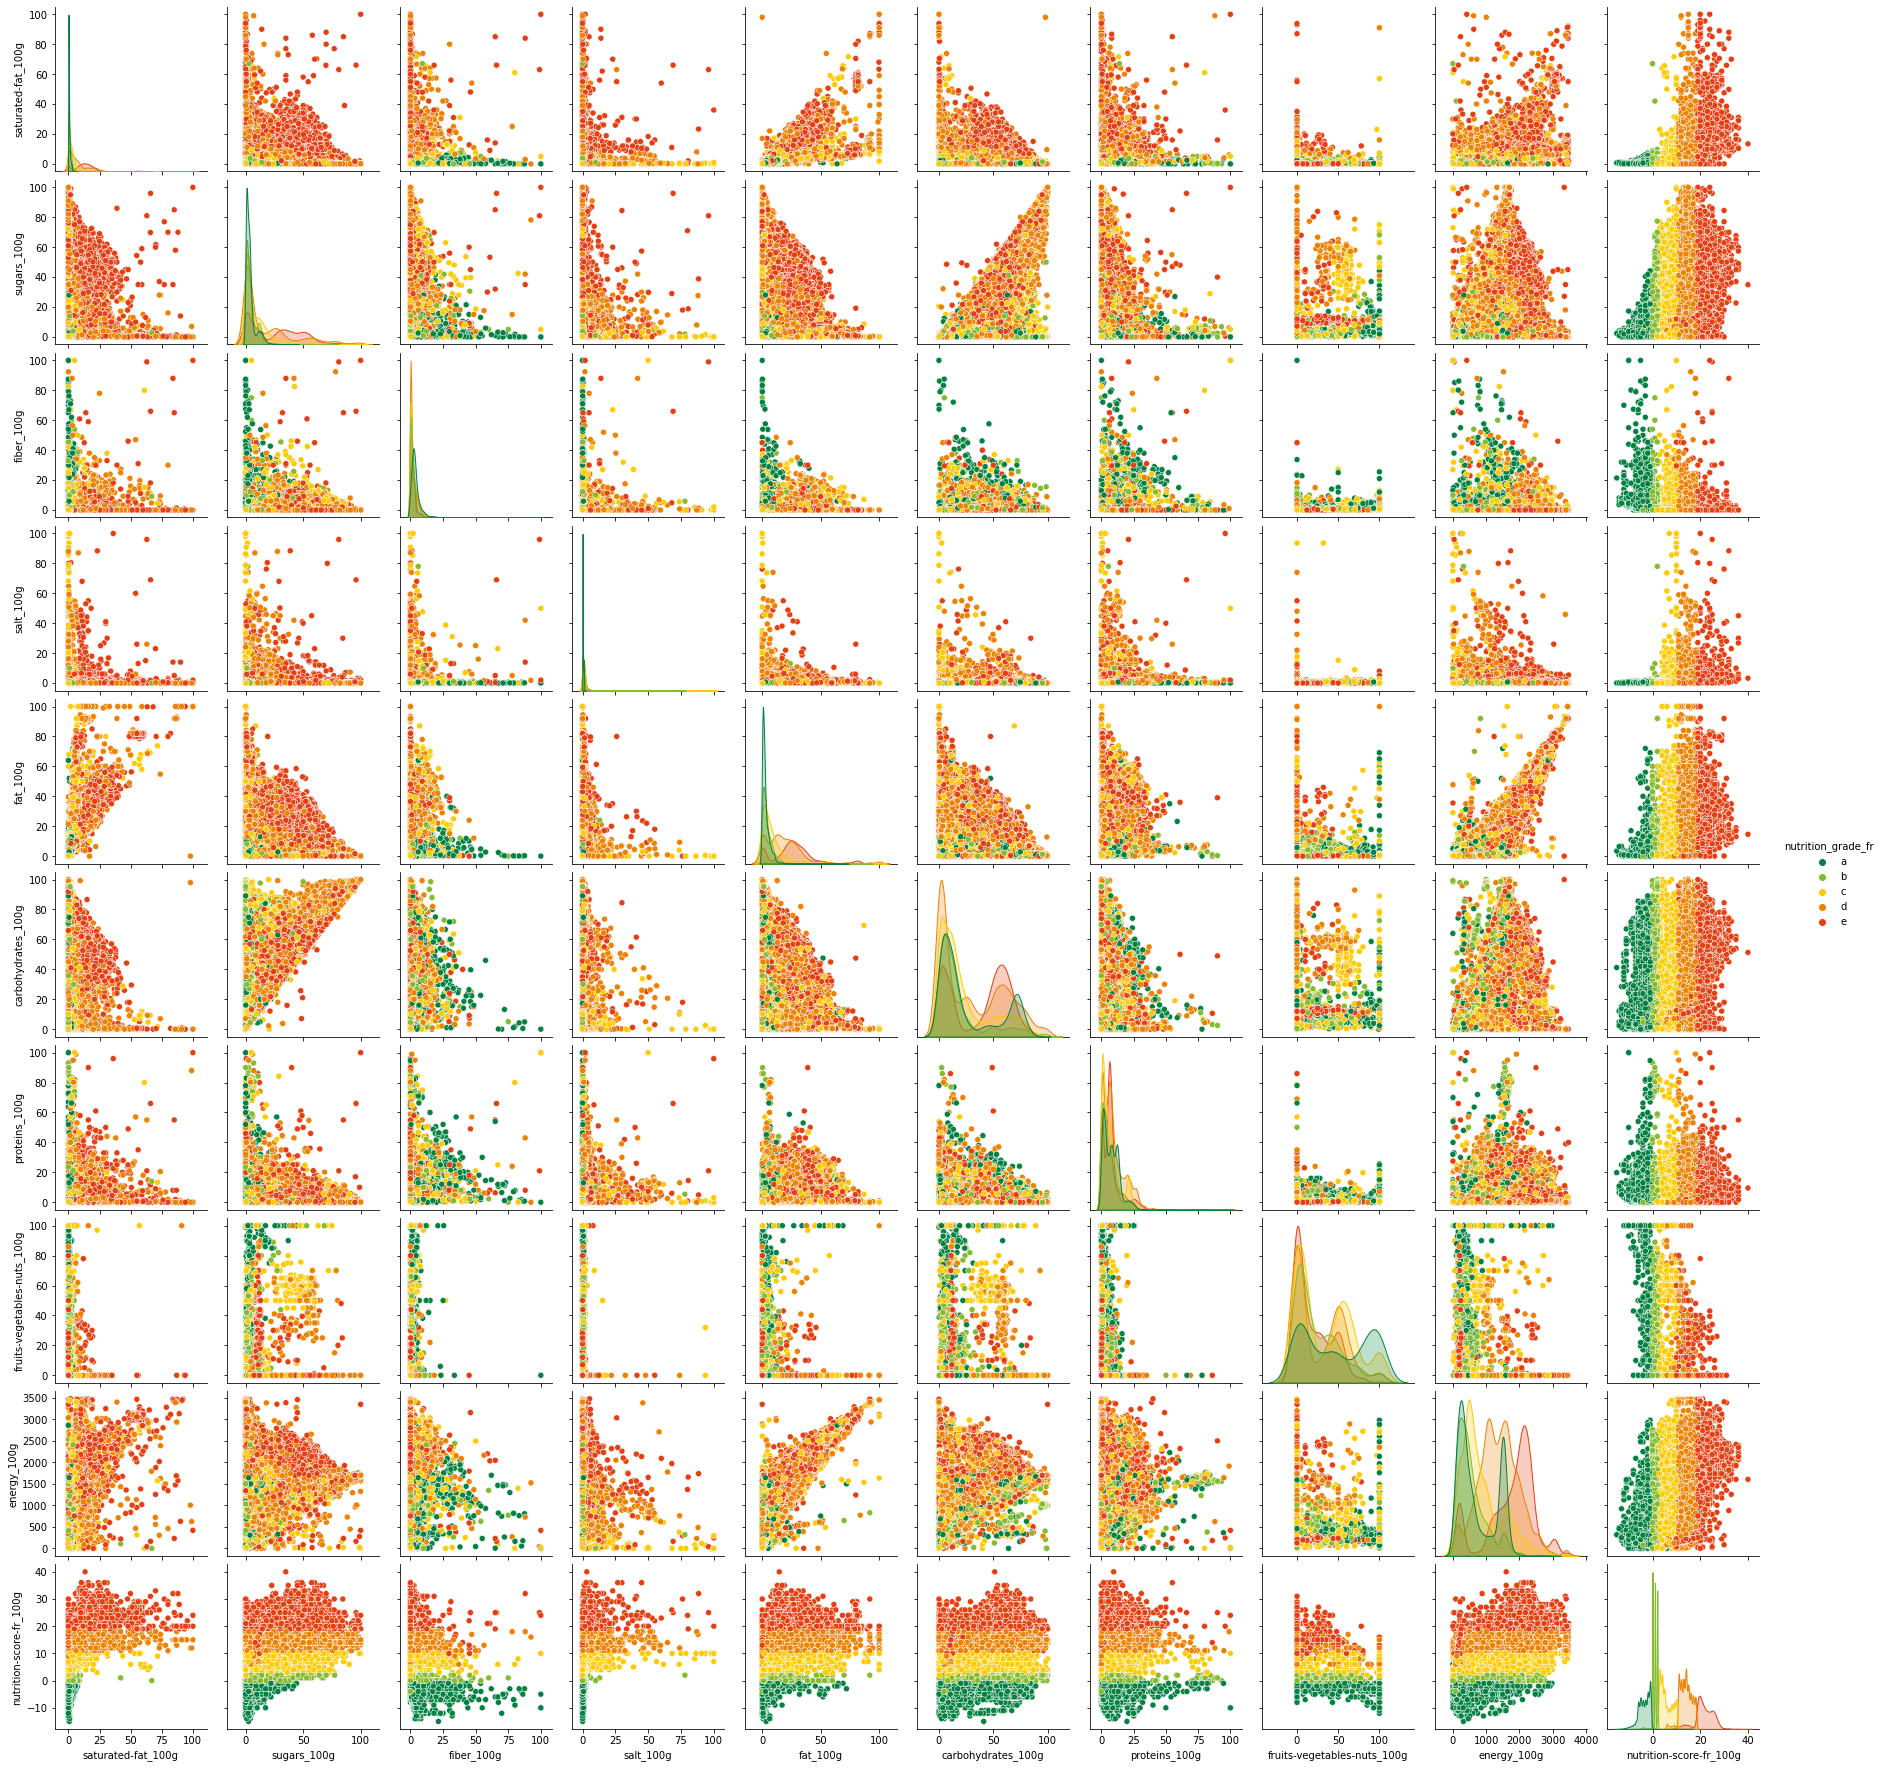

In [108]:
ls_nutrigrade_order = ["a", "b", "c", "d", "e"]
palette_nutrigrade = ["#038141", "#85BB2F", "#FECB02", "#EE8100", "#E63E11"]
sns.pairplot(df_clean[[
                "saturated-fat_100g", 
                "sugars_100g", 
                "fiber_100g",
                "salt_100g", 
                "fat_100g",
                "carbohydrates_100g", 
                "proteins_100g",
                "fruits-vegetables-nuts_100g",
                "nutrition_grade_fr",
                "energy_100g",
                "nutrition-score-fr_100g"]],
            hue="nutrition_grade_fr",
            hue_order=ls_nutrigrade_order,
            palette=palette_nutrigrade)

#### Paires de variables corrélées

In [109]:
# Calcul des coefficients de corrélations
df_corr = df_clean.corr()
tabl = pd.DataFrame(columns = ['valeur', 'paire', 'coeff_correl'])

for col in df_corr:
    # Extraction du plus grand coefficient et de la paire associée
    a = df_corr[col].drop(labels=[col]).abs()
    tabl = tabl.append({'valeur':col, 
                        'paire':a.idxmax(), 
                        'coeff_correl':round(a.max(),2)}, 
                       ignore_index=True)
print(tabl.sort_values(['coeff_correl'], ascending=False))

                         valeur                        paire  coeff_correl
11               vitamin-d_100g               vitamin-c_100g          0.99
12               vitamin-c_100g               vitamin-d_100g          0.99
1                      fat_100g                  energy_100g          0.77
3                   energy_100g                     fat_100g          0.77
4            saturated-fat_100g                     fat_100g          0.74
2            carbohydrates_100g                  sugars_100g          0.64
5                   sugars_100g           carbohydrates_100g          0.64
9       nutrition-score-fr_100g                  energy_100g          0.63
13                    iron_100g               vitamin-d_100g          0.50
8                 proteins_100g  fruits-vegetables-nuts_100g          0.35
10  fruits-vegetables-nuts_100g                proteins_100g          0.35
6                    fiber_100g           carbohydrates_100g          0.25
0   ingredients_from_palm

### Analyse en composante principale

In [110]:
# préparation des données pour l'ACP,
# nous ne garderons que les variables quantitatives
# les valeurs manquantes serons remplacées par la moyenne
df_pca = df_clean[ls_nutri_quanti].fillna(df_clean.mean())

C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_23584/1408830173.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_pca = df_clean[ls_nutri_quanti].fillna(df_clean.mean())


Text(0, 0.5, 'Variance expliquée et cumulée')

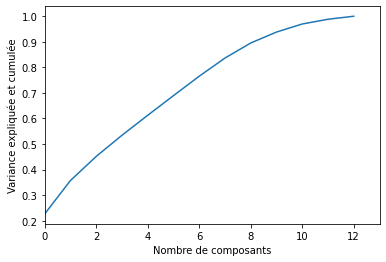

In [111]:
X = df_pca.values
X_std = preprocessing.StandardScaler().fit_transform(X)
pca = decomposition.PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,len(ls_nutri_quanti),1)
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée et cumulée')

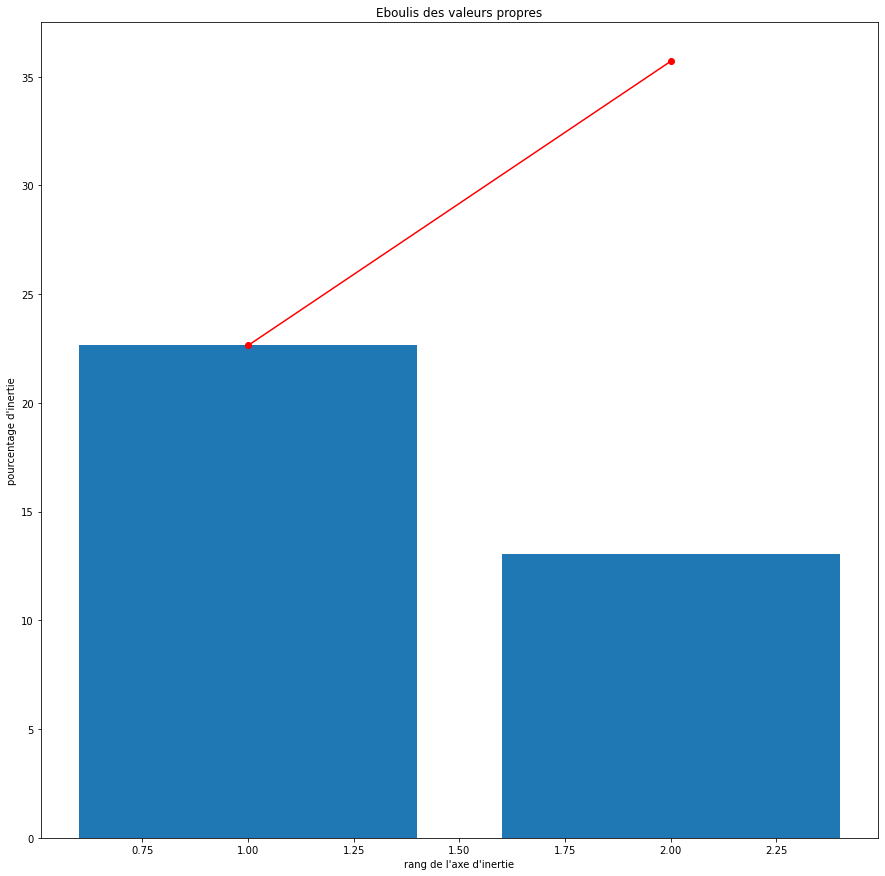

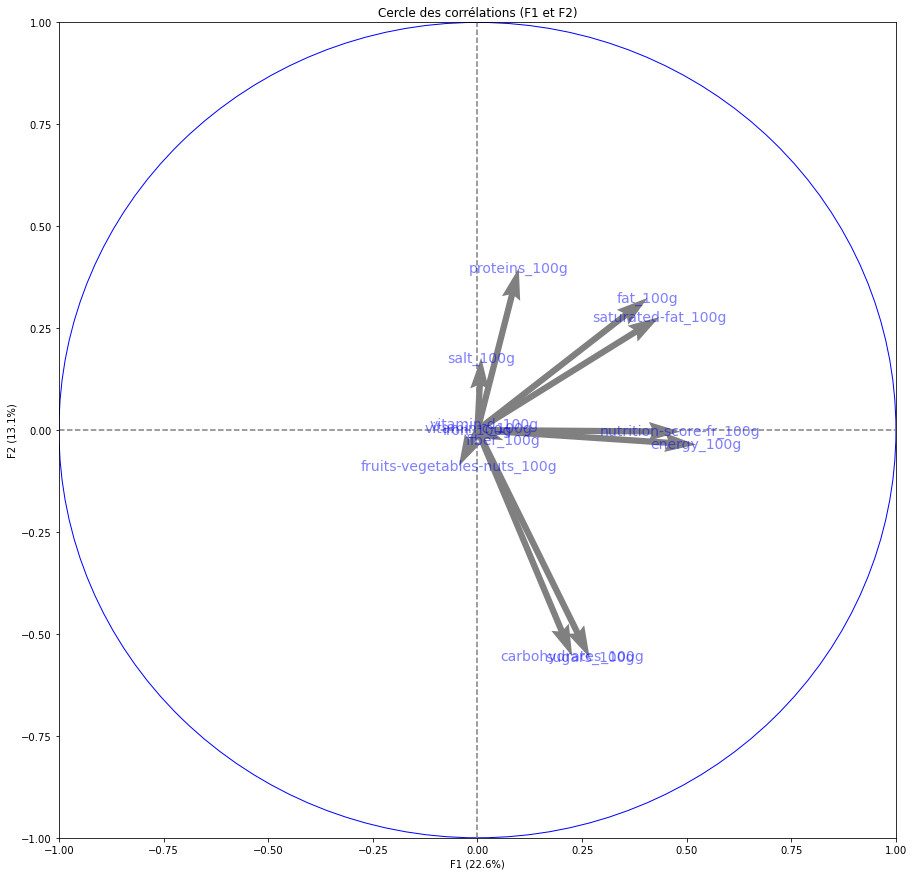

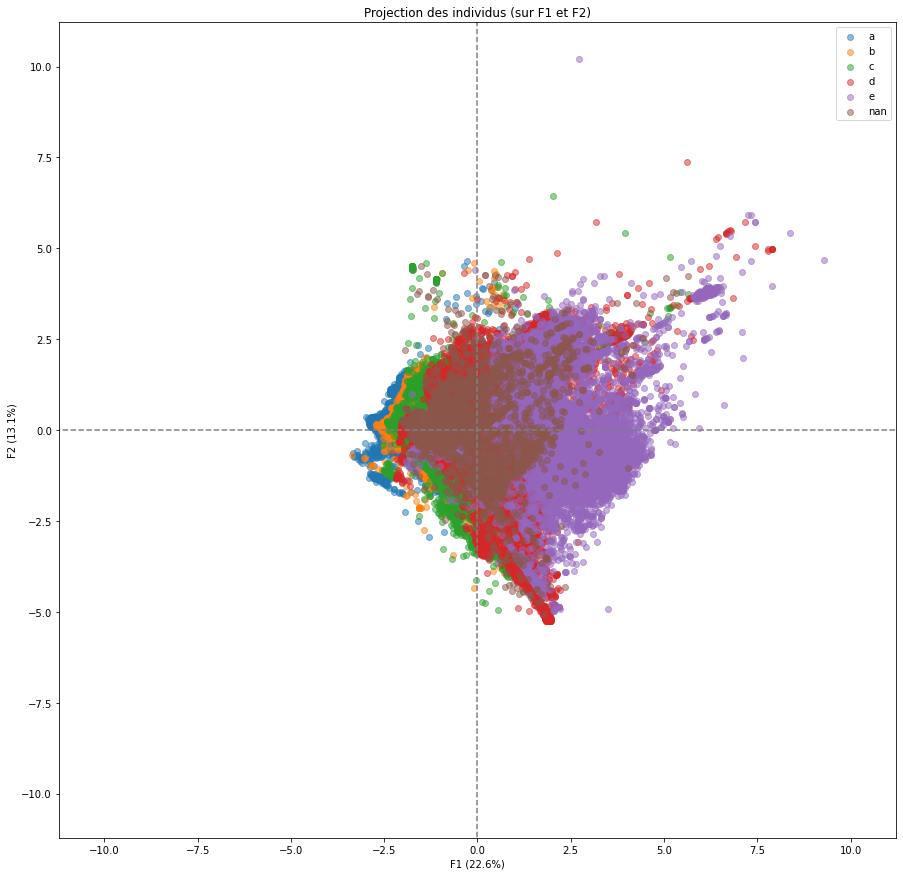

In [112]:
# choix du nombre de composants à calculer
n_comp = 2


X = df_pca.values
names = df_pca.index
features = df_pca.columns

# Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# éboulis des valeurs propres
display_scree_plot(pca)

# cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(ls_nutri_quanti))

# projection des individus
X_projected = pca.transform(X_scaled)
# display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = None, illustrative_var=df_clean["nutrition_grade_fr"].tolist(), alpha=0.5)

plt.show()

Nous pouvons voir ici que certaines variables sont très corrélées :
- ```fat_100g``` et ```saturated-fat_100g```, ce qui semble évident : les graisses saturées sont un type de graisses
- ```carbohydrates_100g``` et ```sugars_100g``` : les sucres sont des glucides
- ```energy_100g``` et ```nutrition-score-fr_100g```

Refaisons cette analyse en composantes principales en enlevant les variables ```saturated-fat_100g```, ```sugars_100g``` et ```energy_100g```

Text(0, 0.5, 'Variance expliquée et cumulée')

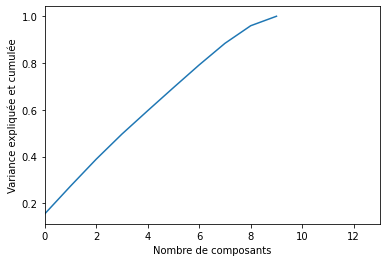

In [113]:
ls_nutri_nocorr = [
    "fat_100g",
    "carbohydrates_100g",
    "fiber_100g",
    "salt_100g",
    "proteins_100g",
    "nutrition-score-fr_100g",
    "fruits-vegetables-nuts_100g",
    "vitamin-d_100g",
    "vitamin-c_100g",
    "iron_100g",
]

X = df_pca[ls_nutri_nocorr].values
X_std = preprocessing.StandardScaler().fit_transform(X)
pca = decomposition.PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,len(ls_nutri_quanti),1)
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée et cumulée')

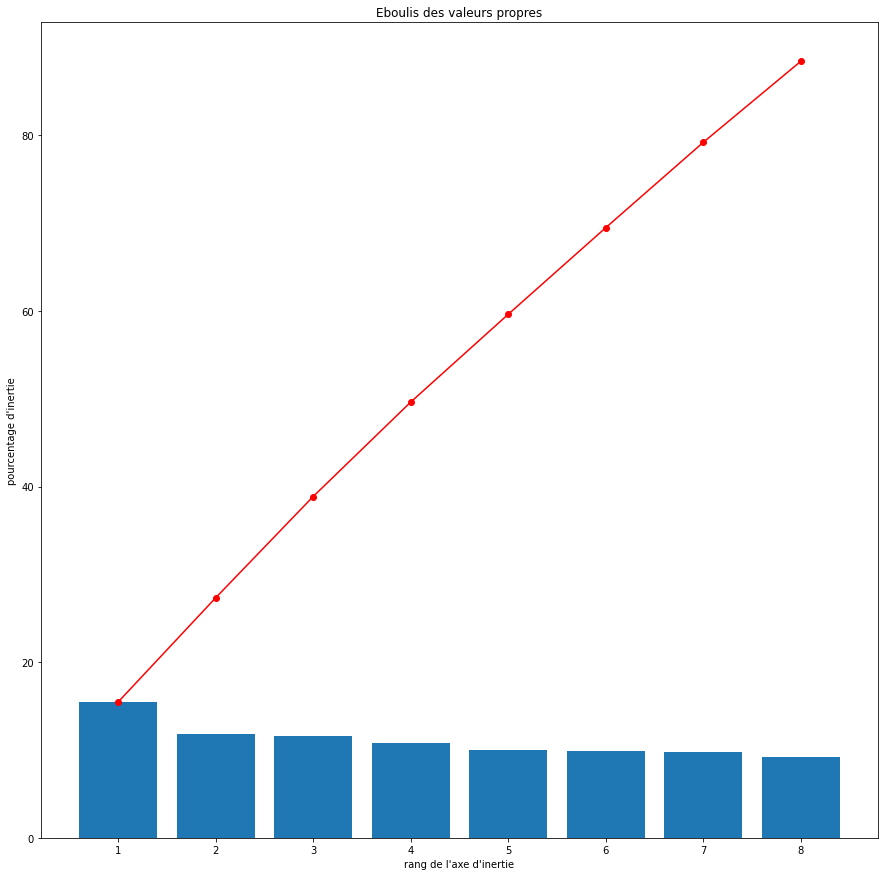

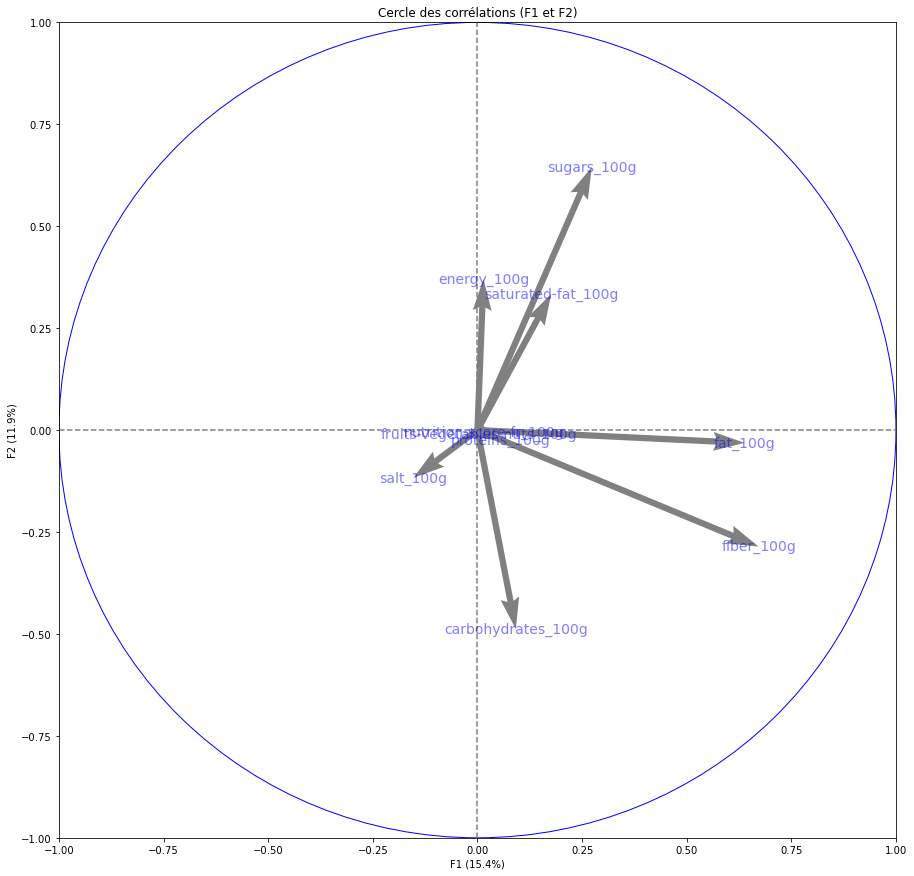

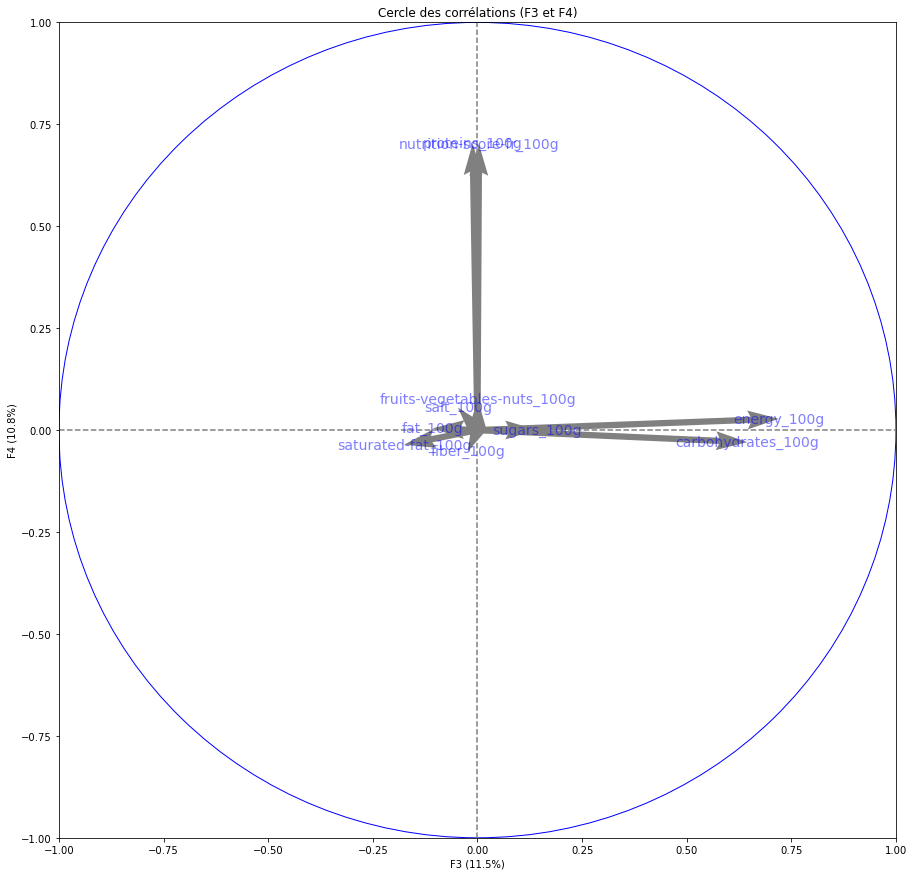

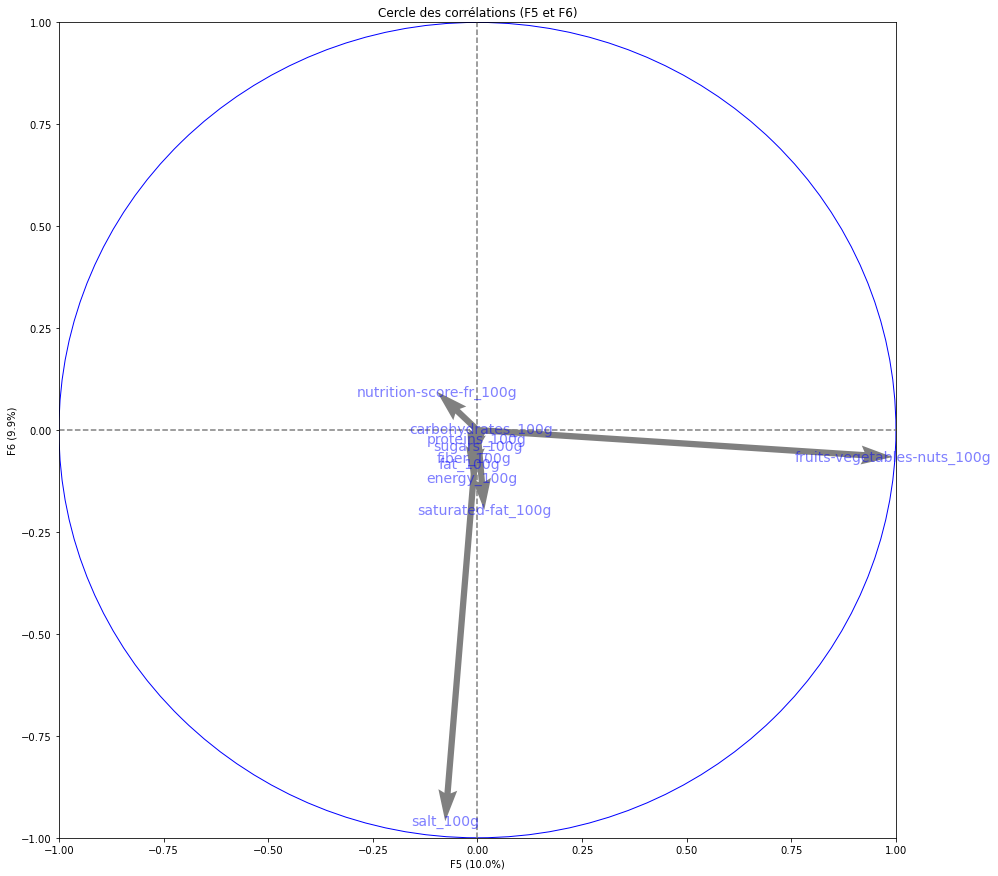

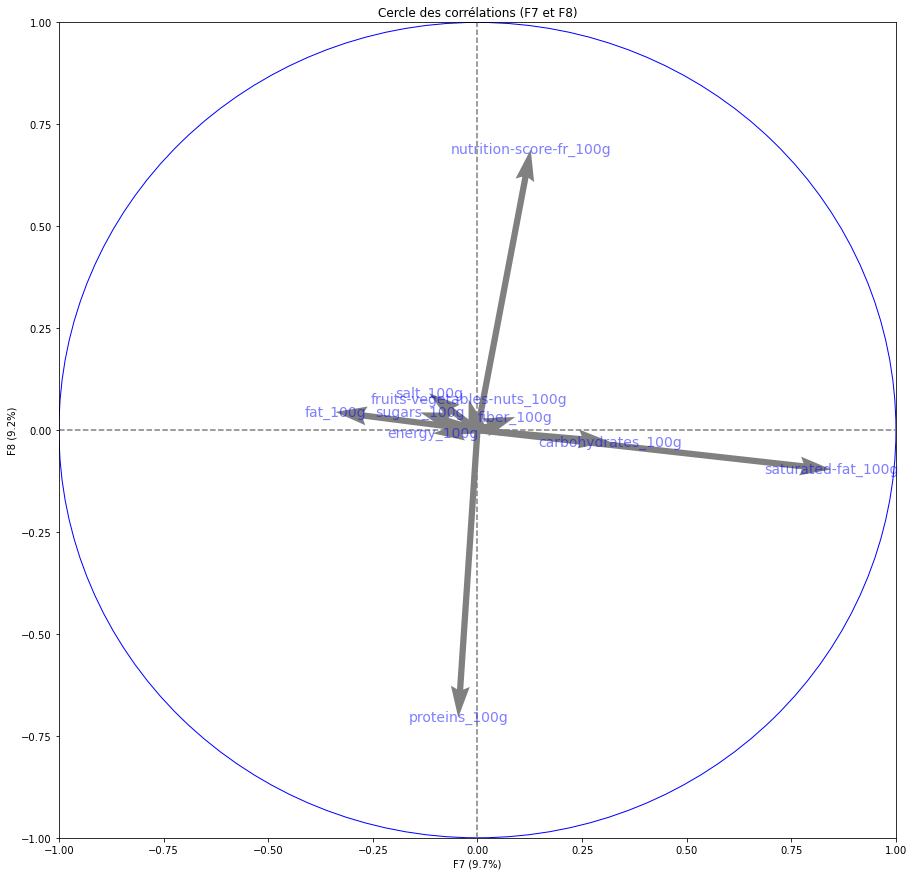

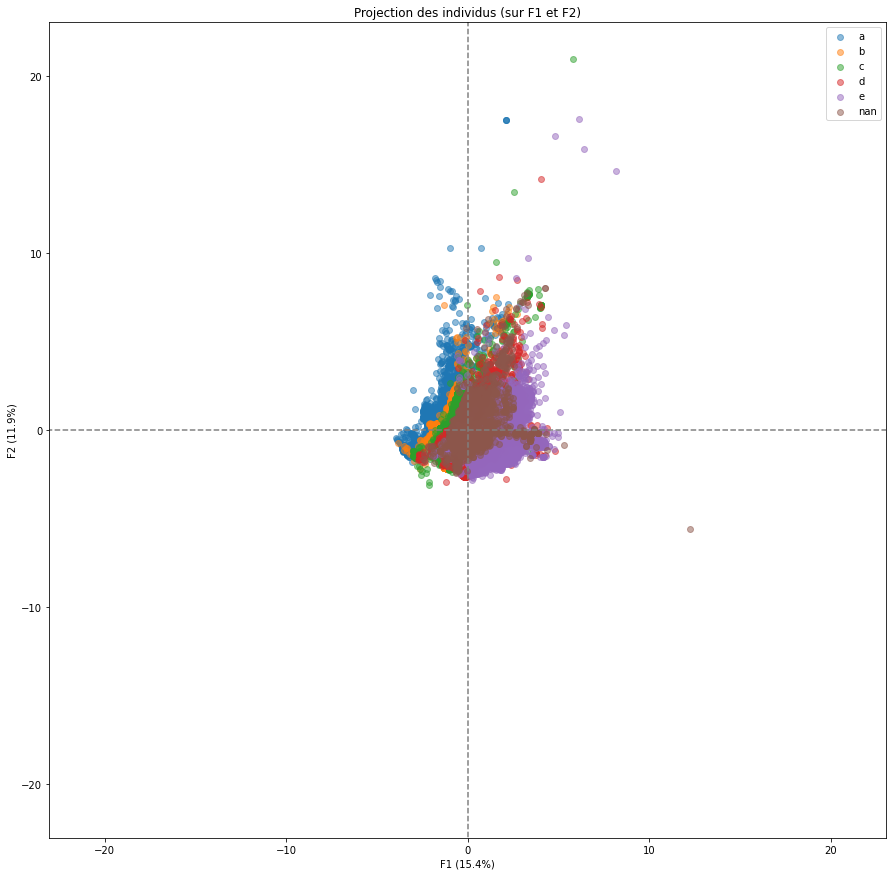

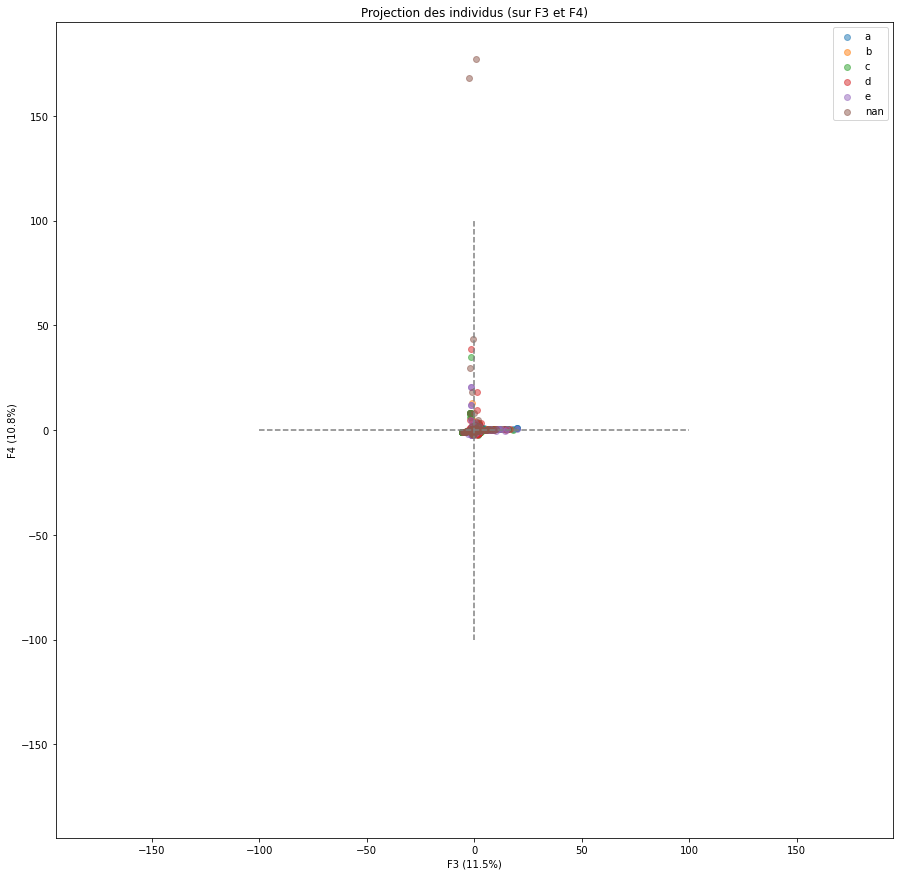

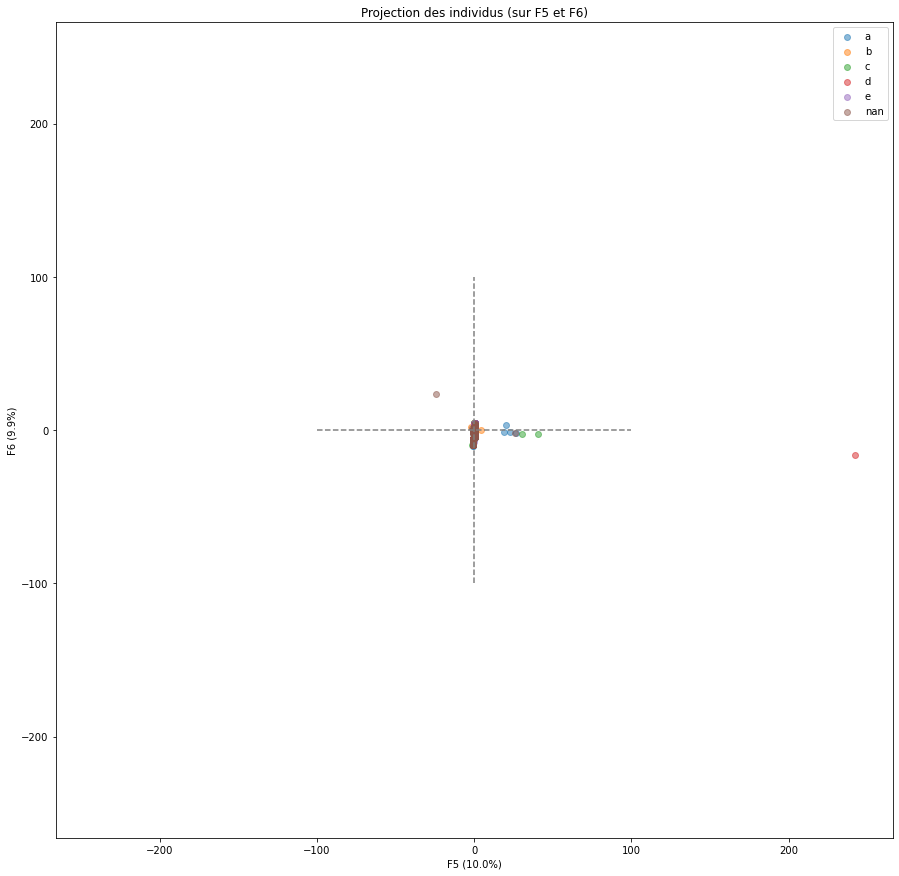

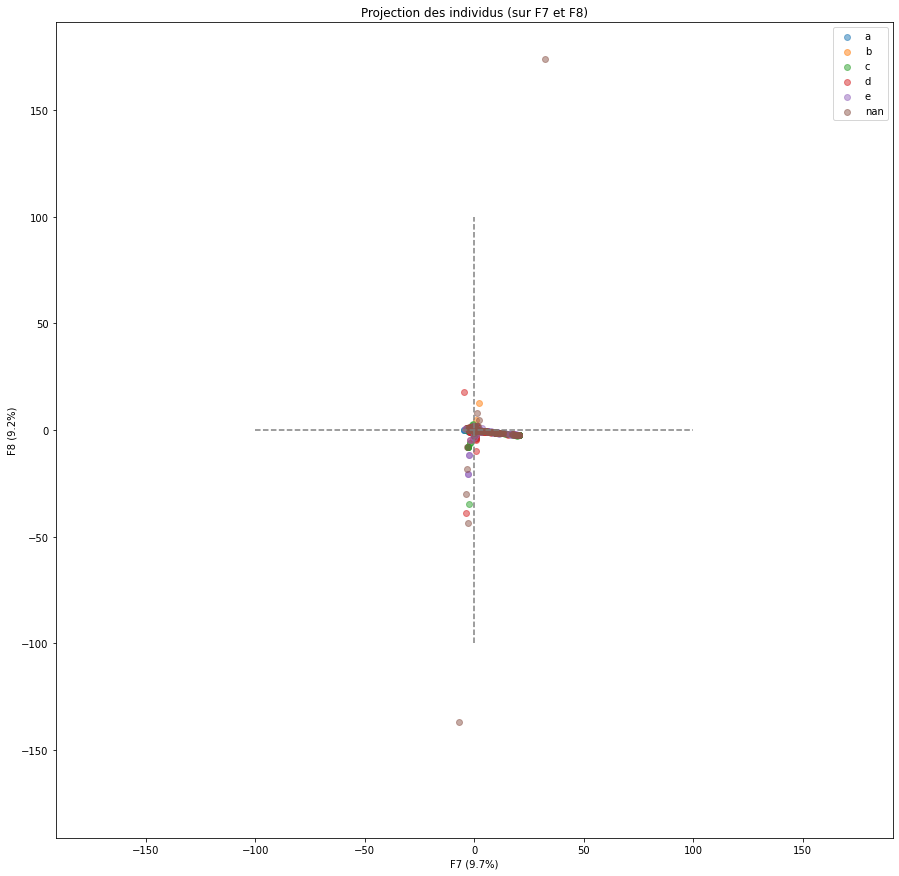

In [114]:
# choix du nombre de composants à calculer
n_comp = 8


X = df_pca[ls_nutri_nocorr].values
names = df_pca.index
features = df_pca.columns

# Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# éboulis des valeurs propres
display_scree_plot(pca)

# cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5),(6,7)], labels = np.array(ls_nutri_quanti))

# projection des individus
X_projected = pca.transform(X_scaled)
# display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5),(6,7)], labels = None, illustrative_var=df_clean["nutrition_grade_fr"].tolist(), alpha=0.5)

plt.show()

#### Cohérence entre les valeurs de ```fat_100g``` et les valeurs de ```saturated-fat_100g```

Les graisses saturées sont des graisses, donc les valeurs de ```fat_100g``` devraient toujours être supérieures ou égales à celles de ```saturated-fat_100g```.

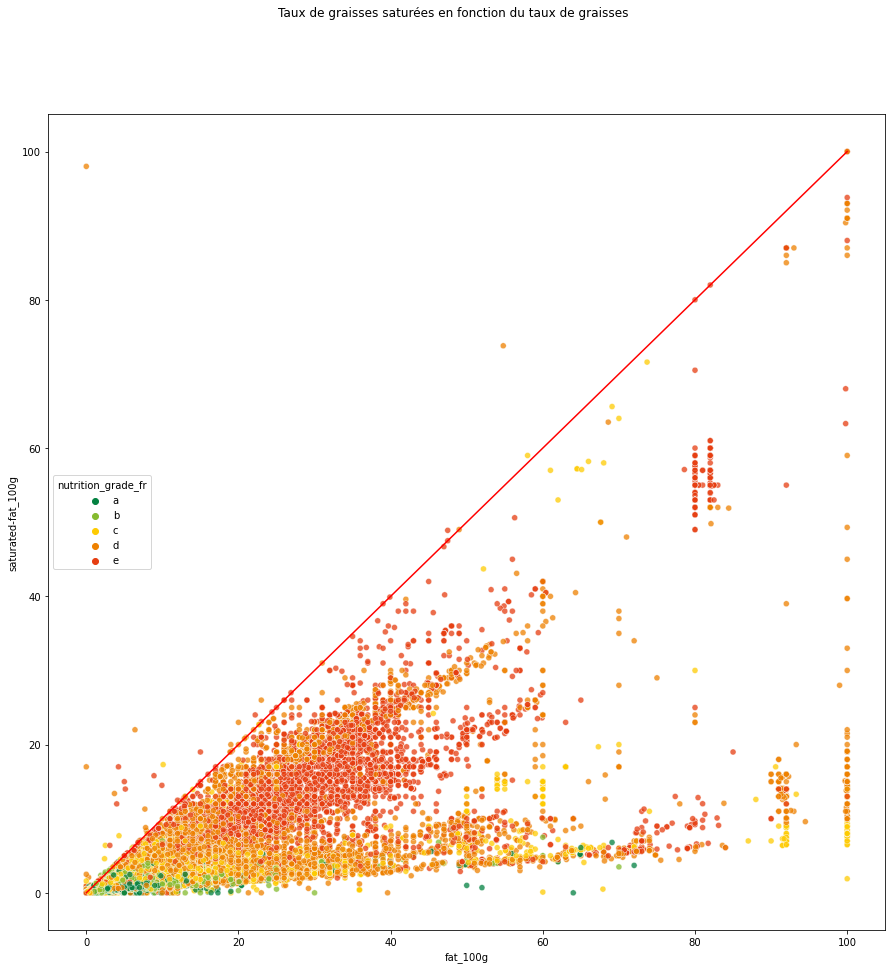

In [115]:
ax = sns.scatterplot(
    data=df_clean,
    x="fat_100g",
    y="saturated-fat_100g",
    hue="nutrition_grade_fr",
    hue_order=["a", "b", "c", "d", "e"],
    palette=["#038141", "#85BB2F", "#FECB02", "#EE8100", "#E63E11"],
    alpha=0.75
)
# droite pour laquelle fat = saturated-fat
x = np.linspace(0,100,3)
y = x
plt.plot(x, y, '-r', label='graisses saturée = graisses')
fig = plt.gcf()
fig.suptitle("Taux de graisses saturées en fonction du taux de graisses")
fig.set_size_inches(15,15)

Tous les points situés au-dessus de la droite rouge sont des anomalies. Nous allons donc remplacer les valeurs de ces points.

In [116]:
# Moyenne des rapports entre graisses et graisses saturées pour les valeurs valides de graisse
# Tel que mean(fat_100g) * coef = mean(saturated-fat_100g)
df_fat = df_clean[(df_clean['saturated-fat_100g'] <= df_clean['fat_100g']) & (df_clean['fat_100g'] <= 100)]
coef_fat = df_fat['saturated-fat_100g'].mean()/df_fat['fat_100g'].mean()
print("mean(fat_100g)*{} = mean(saturated-fat_100g)".format(coef_fat))

mean(fat_100g)*0.39724260161447983 = mean(saturated-fat_100g)


Remplaçons les anomalies dans les valeurs de ```saturated-fat_100g``` par la valeur de ```fat_100g``` correspondante multipliée par le coefficient :

In [117]:
df_clean.loc[(df_clean["fat_100g"] < df_clean["saturated-fat_100g"]), "saturated-fat_100g"] = df_clean["fat_100g"]

Traçons à nouveau la figure précédente pour constater le changement :

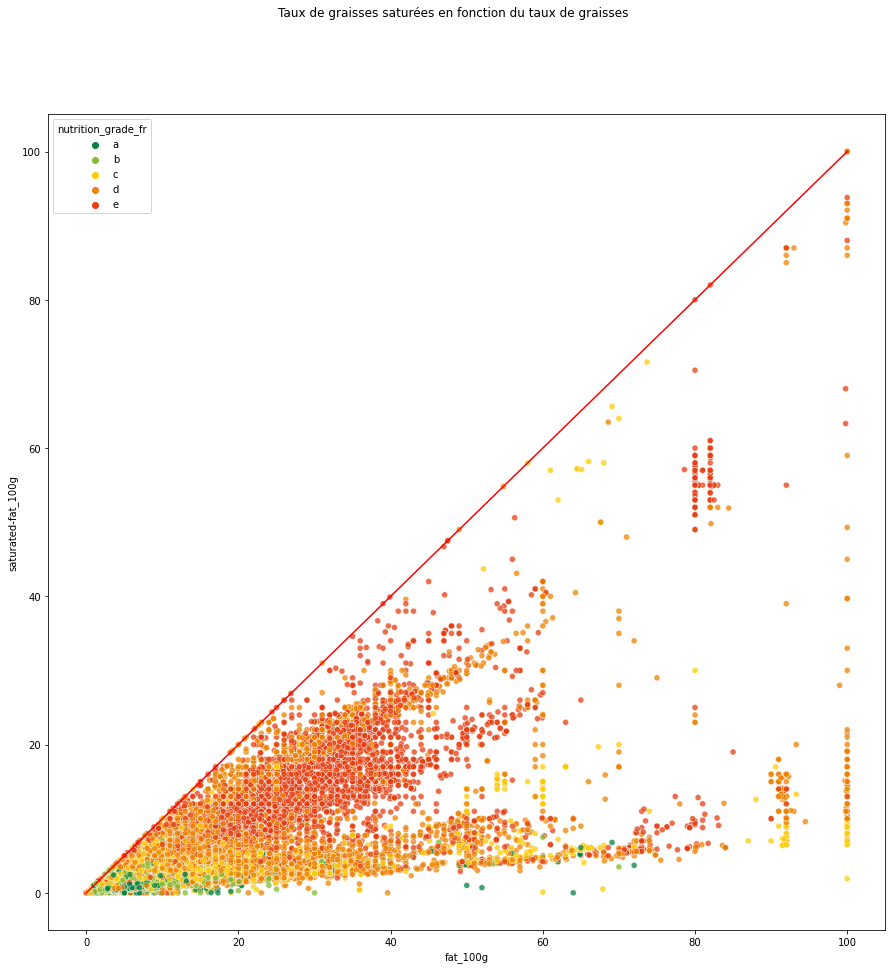

In [118]:
ax = sns.scatterplot(
    data=df_clean,
    x="fat_100g",
    y="saturated-fat_100g",
    hue="nutrition_grade_fr",
    hue_order=["a", "b", "c", "d", "e"],
    palette=["#038141", "#85BB2F", "#FECB02", "#EE8100", "#E63E11"],
    alpha=0.75
)
# droite pour laquelle fat = saturated-fat
x = np.linspace(0,100,3)
y = x
plt.plot(x, y, '-r', label='graisses saturée = graisses')
fig = plt.gcf()
fig.suptitle("Taux de graisses saturées en fonction du taux de graisses")
fig.set_size_inches(15,15)

#### Cohérence entre les valeurs de ```carbohydrates_100g``` et les valeurs de ```sugars_100g```

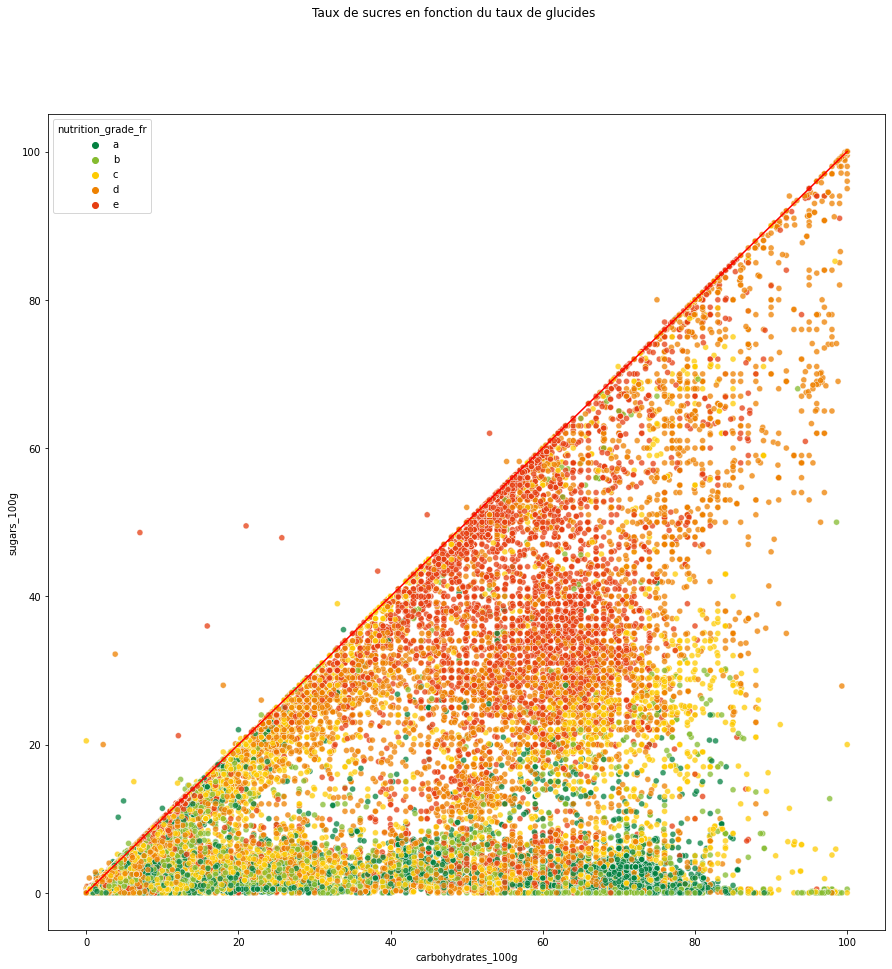

In [119]:
ax = sns.scatterplot(
    data=df_clean,
    x="carbohydrates_100g",
    y="sugars_100g",
    hue="nutrition_grade_fr",
    hue_order=["a", "b", "c", "d", "e"],
    palette=["#038141", "#85BB2F", "#FECB02", "#EE8100", "#E63E11"],
    alpha=0.75
)
# droite pour laquelle sugars = carbohydrates
x = np.linspace(0,100,3)
y = x
plt.plot(x, y, '-r', label='graisses saturée = graisses')
fig = plt.gcf()
fig.suptitle("Taux de sucres en fonction du taux de glucides")
fig.set_size_inches(15,15)

Tous les points situés au-dessus de la droite rouge sont des anomalies. Nous allons donc remplacer les valeurs de ces points.

In [120]:
# Moyenne des rapports entre sucres et glucides pour les valeurs valides de glucides
# Tel que mean(sugars_100g) * coef = mean(carbohydrates_100g)
df_sugars = df_clean[(df_clean['sugars_100g'] <= df_clean['carbohydrates_100g']) & (df_clean['carbohydrates_100g'] <= 100)]
coef_sugars = df_sugars['sugars_100g'].mean()/df_sugars['carbohydrates_100g'].mean()
print("mean(carbohydrates_100g)*{} = mean(sugars_100g)".format(coef_sugars))

mean(carbohydrates_100g)*0.4609560966165097 = mean(sugars_100g)


Remplaçons les anomalies dans les valeurs de ```sugars_100g``` par la valeur de ```carbohydrates_100g``` correspondante multipliée par le coefficient :

In [121]:
df_clean.loc[(df_clean["carbohydrates_100g"] < df_clean["sugars_100g"]), "sugars_100g"] = df_clean["carbohydrates_100g"]

Traçons à nouveau la figure précédente pour constater le changement :

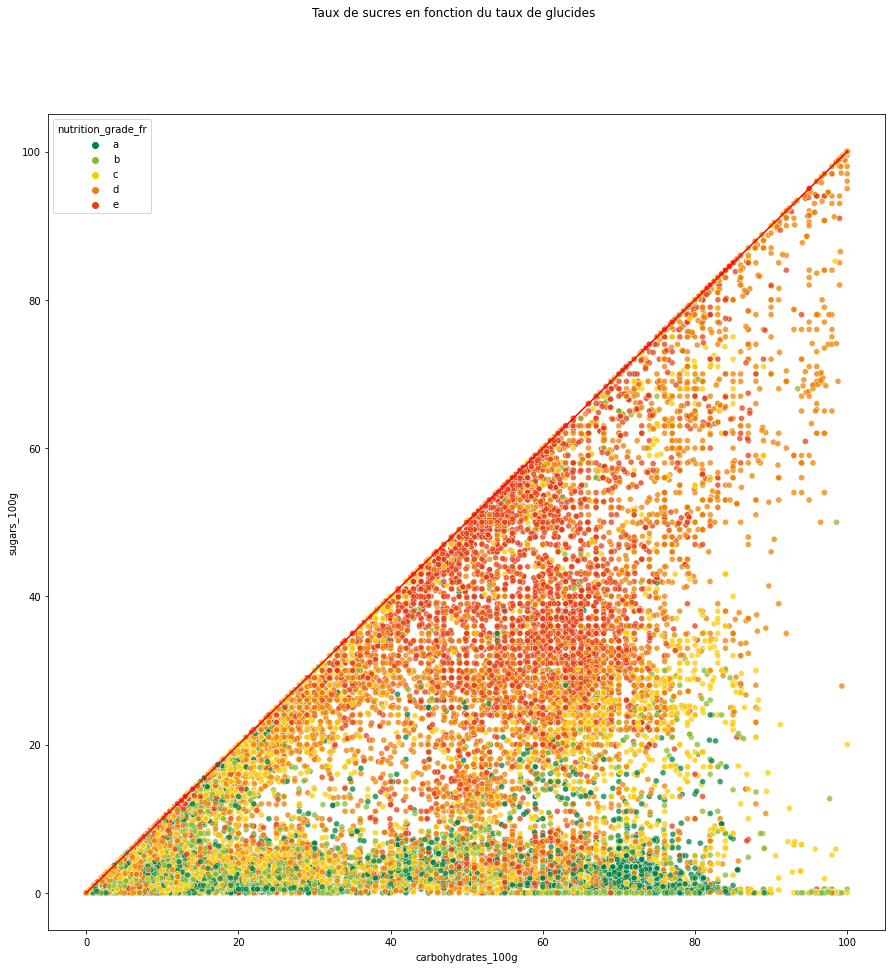

In [122]:
ax = sns.scatterplot(
    data=df_clean,
    x="carbohydrates_100g",
    y="sugars_100g",
    hue="nutrition_grade_fr",
    hue_order=["a", "b", "c", "d", "e"],
    palette=["#038141", "#85BB2F", "#FECB02", "#EE8100", "#E63E11"],
    alpha=0.75
)
# droite pour laquelle sugars = carbohydrates
x = np.linspace(0,100,3)
y = x
plt.plot(x, y, '-r', label='graisses saturée = graisses')
fig = plt.gcf()
fig.suptitle("Taux de sucres en fonction du taux de glucides")
fig.set_size_inches(15,15)

#### Energie pour 100g (```energy_100g```) et graisses (```fat_100g```)

Il y a une corrélation assez forte entre ces deux colonnes (le coefficient est de 0.77). Traçons un graphique pour le constater et voir si on peut envisager de calculer l'énergie à partir du taux de graisses pour 100g par régression linéaire.

Text(0, 0.5, 'Graisse')

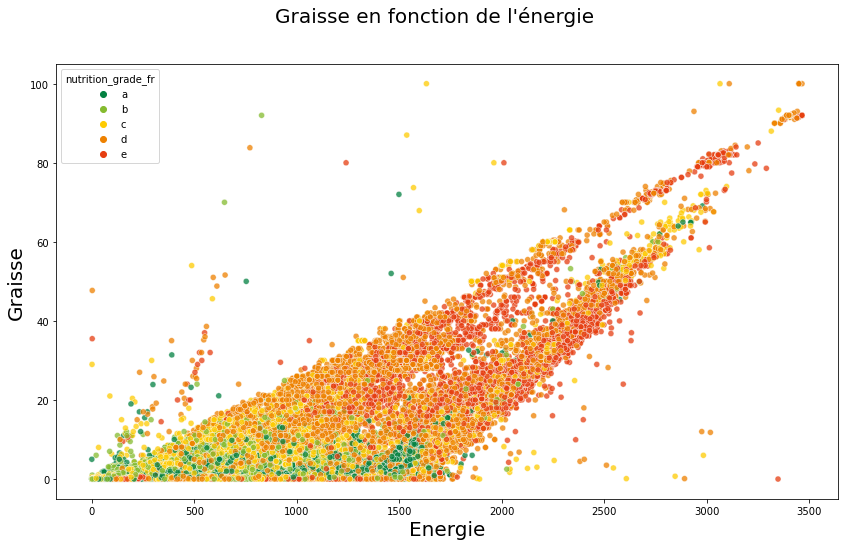

In [123]:
ax = sns.scatterplot(data=df_clean,
                     x='energy_100g', 
                     y='fat_100g',
                     hue="nutrition_grade_fr",
                     hue_order=["a", "b", "c", "d", "e"],
                     palette=["#038141", "#85BB2F", "#FECB02", "#EE8100", "#E63E11"],
                     alpha=0.75
                    )

fig = plt.gcf()
fig.suptitle("Graisse en fonction de l'énergie", fontsize=20);
fig.set_size_inches(14,8)
plt.xlabel("Energie", fontsize=20)
plt.ylabel("Graisse", fontsize=20, rotation=90)

Affichons un tableau des coefficients de correlations pour voir s'il y a d'autres colonnes qui pourraient nous intéresser pour déduire l'énergie pour 100g 

In [124]:
df_corr['energy_100g'].abs().sort_values(ascending=False)

energy_100g                    1.000000
fat_100g                       0.769070
nutrition-score-fr_100g        0.632936
saturated-fat_100g             0.576853
carbohydrates_100g             0.559322
vitamin-d_100g                 0.388390
sugars_100g                    0.349419
fruits-vegetables-nuts_100g    0.285625
proteins_100g                  0.228027
fiber_100g                     0.223284
ingredients_from_palm_oil_n    0.203714
iron_100g                      0.023975
salt_100g                      0.023679
vitamin-c_100g                 0.011619
Name: energy_100g, dtype: float64

- On élimine la colonne ```saturated-fat_100g``` car elle est assez fortement corrélée à la colonne ```fat_100g```
- Pour la même raison, on élimine la colonne ```sugars_100g``` car trop corrélée à la colonne ```carbohydrates_100g```
- La colonne ```vitamin-d_100g``` a des valeurs trop peu réparties
- Les colonnes ```fruits-vegetables-nuts_100g``` et ```ingredients_from_palm_oil_n``` ont trop de valeurs manquantes

Nous allons donc retenir les colonnes suivantes :
- ```fat_100g```
- ```carbohydrates_100g```
- ```proteins_100g```
- ```fiber_100g```

##### Régression linéaire

Nous allons dans un premier temps échantilloner les données pour ne garder que les lignes pour lesquelles la colonne ```energy_100g``` est renseignée

In [125]:
df_reg = df_clean[["energy_100g", 
                    "fat_100g",
                    "nutrition-score-fr_100g",
                    "carbohydrates_100g",
                    "proteins_100g",
                    "fiber_100g"]].dropna()

# features
X = df_reg[[
    "fat_100g",
    "nutrition-score-fr_100g",
    "carbohydrates_100g",
    "proteins_100g",
    "fiber_100g"
]]

# targets
Y = df_reg["energy_100g"]

# # séparation des données en training/test sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# # Entrainement de l'algorithme
# rg = LinearRegression().fit(X_train, Y_train)
rg =LinearRegression().fit(X, Y)

# prediction
nrg_pred = rg.predict(X)

print("Coefficient : {}".format(rg.coef_))
print("Erreur quadratique moyenne : {}".format(mean_squared_error(Y, nrg_pred)))
print("Coefficient de détermination : {}".format(r2_score(Y, nrg_pred)))

Coefficient : [36.0872485   1.9223679  16.37215218 16.96208327  8.08340287]
Erreur quadratique moyenne : 13337.038239817184
Coefficient de détermination : 0.9759883311104692


Text(0, 0.5, 'Energie prédite')

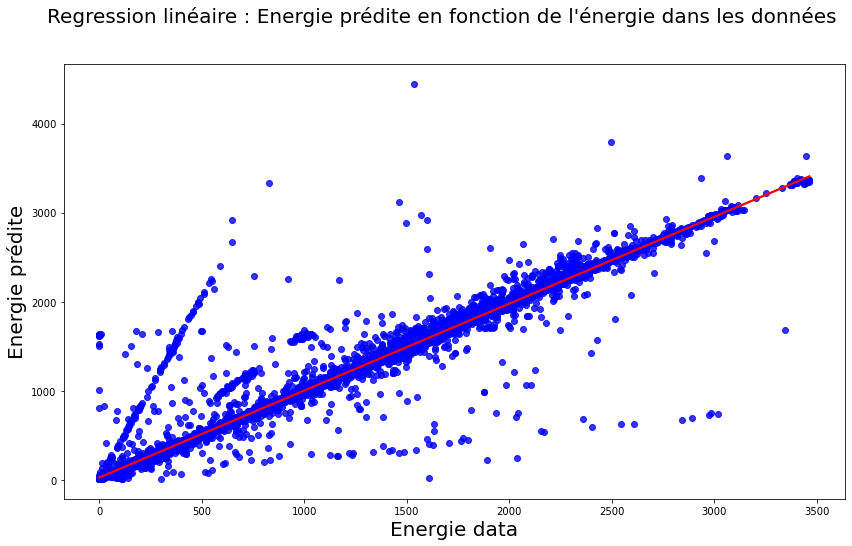

In [126]:
ax = sns.regplot(x=df_reg['energy_100g'], 
                 y=nrg_pred, scatter_kws={"color": "blue"}, 
                 line_kws={"color": "red"})
fig = plt.gcf()
fig.set_size_inches(14,8)
fig.suptitle("Regression linéaire : Energie prédite en fonction de l'énergie dans les données", fontsize=20);
plt.xlabel("Energie data", fontsize=20)
plt.ylabel("Energie prédite", fontsize=20, rotation=90)

Nous pouvons maintenant utiliser cette régression linéaire pour prédire les valeurs manquantes dans la colonne ```energy_100g```:

In [127]:
print("valeurs manquantes avant régression linéaire")
display(df_clean["energy_100g"].max())


df_tmp = df_clean.dropna(subset=["fat_100g","nutrition-score-fr_100g", "carbohydrates_100g", "proteins_100g","fiber_100g"])
df_tmp["energy_100g"] = df_tmp.apply(
    lambda row: rg.predict(row[['fat_100g',"nutrition-score-fr_100g", 'carbohydrates_100g', 'proteins_100g', 'fiber_100g']].to_frame().transpose())
    if np.isnan(row['energy_100g']) 
    else row['energy_100g'],
    axis = 1
)

# nombre de valeurs manquantes dans la colonne avant remplacement
df_mrates = get_missing_val_rates(df_clean)
display(df_mrates.loc["energy_100g"])

# remplacement des valeurs manquantes que l'on a pu déduire (celles pour lesquelles il n'y avait pas de valeurs manquantes dans les features)
df_clean["energy_100g"].loc[df_clean.index & df_tmp.index] = df_tmp["energy_100g"]
df_clean["energy_100g"].loc[df_clean["energy_100g"].apply(lambda x: isinstance(x, np.ndarray))] = df_clean["energy_100g"].loc[df_clean["energy_100g"].apply(lambda x: isinstance(x, np.ndarray))].apply(lambda x: x[0])
# df_clean["energy_100g"]

df_mrates = get_missing_val_rates(df_clean)
print("valeurs manquantes après regression linéaire")
display(df_mrates.loc["energy_100g"])

valeurs manquantes avant régression linéaire


3477.0

C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_23584/3112054961.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["energy_100g"] = df_tmp.apply(


column_name        energy_100g
percent_missing       1.853505
Name: energy_100g, dtype: object

valeurs manquantes après regression linéaire


C:\Users\UTILIS~1\AppData\Local\Temp/ipykernel_23584/3112054961.py:18: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  df_clean["energy_100g"].loc[df_clean.index & df_tmp.index] = df_tmp["energy_100g"]
C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


column_name        energy_100g
percent_missing       1.654915
Name: energy_100g, dtype: object

#### Vitamine C ```vitamin-c_100g``` et vitamine D ```vitamin-D_100g```

Text(0, 0.5, 'Vitamine D pour 100g')

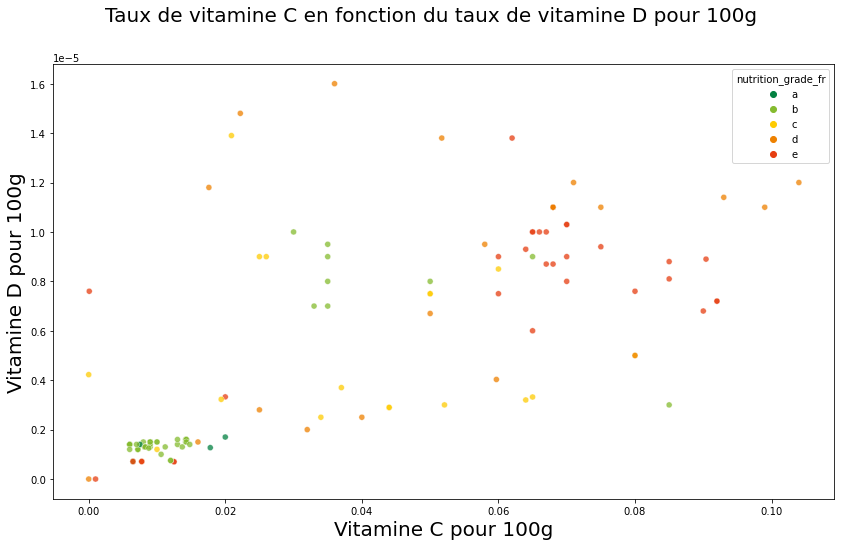

In [128]:
ax = sns.scatterplot(data=df_clean,
                     x='vitamin-c_100g', 
                     y='vitamin-d_100g',
                     hue="nutrition_grade_fr",
                     hue_order=["a", "b", "c", "d", "e"],
                     palette=["#038141", "#85BB2F", "#FECB02", "#EE8100", "#E63E11"],
                     alpha=0.75
                    )

fig = plt.gcf()
fig.suptitle("Taux de vitamine C en fonction du taux de vitamine D pour 100g", fontsize=20);
fig.set_size_inches(14,8)
plt.xlabel("Vitamine C pour 100g", fontsize=20)
plt.ylabel("Vitamine D pour 100g", fontsize=20, rotation=90)

In [129]:
df_mrates.loc[["vitamin-c_100g", "vitamin-d_100g"]]

column_name  percent_missing
vitamin-c_100g  vitamin-c_100g        98.003325
vitamin-d_100g  vitamin-d_100g        99.090181

La corrélation élevée que nous avons vu dans le tableau de corrélations s'explique par le nombre élevé de valeurs manquantes pour les deux colonnes

### Imputation KNN des valeurs manquantes de ```nutrition_grade_fr```

In [130]:
cols_imput = ls_nutri_quanti + ["nutrition_grade_fr"]

#### encodage des labels de nutrition_grade_fr

In [131]:
le = preprocessing.LabelEncoder()
le.fit(df_clean['nutrition_grade_fr'])
df_clean['nutrition_grade_fr'] = np.where(le.transform(df_clean['nutrition_grade_fr']) == 5, 
                                          np.nan, le.transform(df_clean['nutrition_grade_fr']))

#### détermination de la meilleure valeur de n_neighbors

In [132]:
df_imp = df_clean.copy()
df_imp[ls_nutri_quanti] = df_imp[ls_nutri_quanti].fillna(value=0)
df_imp.dropna(subset=['nutrition_grade_fr'], inplace=True)
# df_imp[cols_imput].isna().sum()

X = df_imp[cols_imput].copy()
y = df_imp['nutrition_grade_fr'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model = make_pipeline(KNNImputer(), SGDClassifier())

params = {'knnimputer__n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8]}

grid = GridSearchCV(model, param_grid=params, cv=5)

grid.fit(X_train, y_train)
grid.best_params_

{'knnimputer__n_neighbors': 3}

Nous avons déterminé que la meilleure valeur pour le paramètre ```n_neighbors``` est 5

#### Imputation des valeurs manquantes pour ```nutrition_grade_fr```

In [133]:
df_num = df_clean[cols_imput].copy()
imputer = KNNImputer(n_neighbors=5)
df_num[cols_imput] = imputer.fit_transform(df_num[cols_imput])

Arrondissons les valeurs déterminées par **KNNImputer** pour retomber sur des valeurs entières

In [134]:
df_num['nutrition_grade_fr'] = df_num['nutrition_grade_fr'].apply(math.floor)

#### décodage des valeurs de ```nutrition_grade_fr```

In [135]:
df_num['nutrition_grade_fr'] = le.inverse_transform(df_num['nutrition_grade_fr'])
df_clean[cols_imput] = df_num[cols_imput].copy()

### Imputation des valeurs manquantes de ```nutrition-score-fr_100g```

Imputons les valeurs manquantes de ```nutrition-score-fr_100g``` par la moyenne corespondant au ```nutrition_grade_fr``` associé :

In [143]:
nutri_grade_map = {}
for val in df_clean['nutrition_grade_fr'].unique():
    nutri_grade_map[val] = df_clean['nutrition-score-fr_100g'][df_clean['nutrition_grade_fr'] == val].mean()

# Imputation des valeurs manquantes de nutrition-score-fr_100g 
# par la moyenne corespondant au bon nutrition_grade_fr
for i in df_clean.index:
    if str(df_clean['nutrition-score-fr_100g'][i]) == 'nan':
        df_clean['nutrition-score-fr_100g'][i] = nutri_grade_map[df_clean['nutrition_grade_fr'][i]]

### Imputation KNN des valeurs manquantes des variables quantitatives

In [63]:
ls_knn = [
        'product_name',
        'brands',
        'countries_fr',
        'pnns_groups_1',
        'ingredients_text',
        'allergens',
        'traces',
        'additives',
        'ingredients_from_palm_oil_n',
        'nutrition_grade_fr',
        'states',
        'states_tags',
        'states_fr',
]
df_imputed = impute_KNN(df_clean, ls_knn)

In [64]:
get_missing_val_rates(df_imputed)

column_name  percent_missing
traces                                            traces        73.549062
allergens                                      allergens        68.365713
pnns_groups_1                              pnns_groups_1        33.860341
additives                                      additives        31.900613
ingredients_text                        ingredients_text        31.888297
nutrition_grade_fr                    nutrition_grade_fr         5.917670
brands                                            brands         0.626559
product_name                                product_name         0.532652
sugars_100g                                  sugars_100g         0.000000
vitamin-c_100g                            vitamin-c_100g         0.000000
vitamin-d_100g                            vitamin-d_100g         0.000000
fruits-vegetables-nuts_100g  fruits-vegetables-nuts_100g         0.000000
nutrition-score-fr_100g          nutrition-score-fr_100g         0.000000
proteins_100g                              proteins_100g         0.000000
salt_100g                                      salt_100g         0.000000
fiber_100g                                    fiber_100g         0.000000
fat_100g                                        fat_100g         0.000000
saturated-fat_100g                    saturated-fat_100g         0.000000
energy_100g                                  energy_100g         0.000000
carbohydrates_100g                    carbohydrates_100g         0.000000
states_fr                                      states_fr         0.000000
states_tags                                  states_tags         0.000000
states                                            states         0.000000
ingredients_from_palm_oil_n  ingredients_from_palm_oil_n         0.000000
countries_fr                                countries_fr         0.000000
iron_100g                                      iron_100g         0.000000

### répartition des ```nutrition_grade_fr``` par catégorie de ```pnns_groups_1```

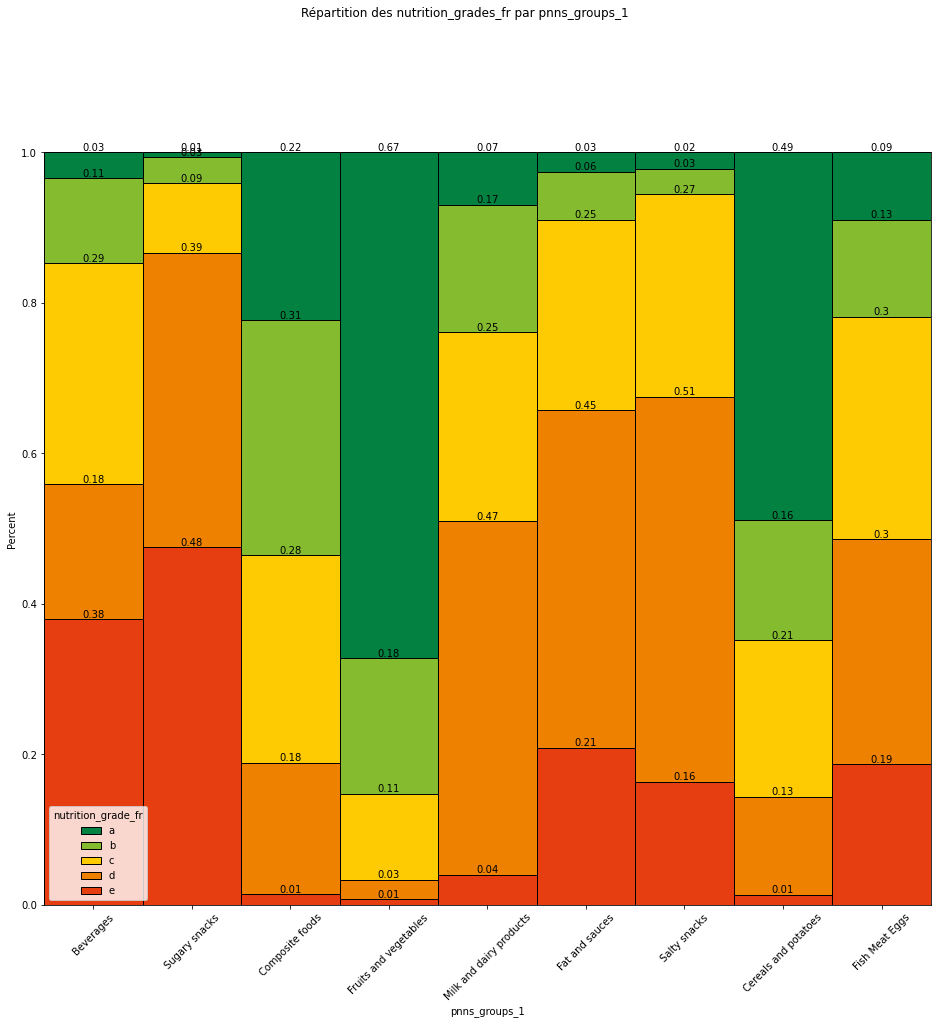

In [190]:
g = sns.histplot(x='pnns_groups_1',
                 data=df_clean,
                 hue=df_clean['nutrition_grade_fr'],
                 hue_order=["a", "b", "c", "d", "e"],
                 palette=palette_nutrigrade,
                 alpha=1,
                 multiple="fill",
                 stat="percent")
# g.bar_label(g.containers[0])
for c in g.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [round(v.get_height(),2) if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    g.bar_label(c , labels=labels, label_type='edge')
fig = plt.gcf()
fig.suptitle("Répartition des nutrition_grades_fr par pnns_groups_1")
plt.tight_layout()
plt.xticks(rotation=45)
fig.set_size_inches(15,15)
plt.show()

### ANOVA

Il s'agit ici d'étudier l'impact d'une variable qualitative sur une variable quantitative. Nous allons d'abord étudier étudier l'impact de la variable ```pnns_groups_1``` sur la variable ```nutrition-score-fr_100g```.

**La catégorie du produit a-t'elle un impact sur la note nutritionnelle ?**

Nous avons 9 actégories de produits :
- ```'Beverages'```, les boissons
- ```'Sugary snacks'```, les collations sucrées
- ```'Composite foods'```, les aliments composés (contiennent, comme ingrédients, des aliments appartenant à plusieurs groupes alimentaires)
- ```'Fruits and vegetables'```, les fruits et légumes
- ```'Milk and dairy products'```, les produits laitiers
- ```'Fat and sauces'```, les sauces et huiles
- ```'Salty snacks'```, les collations salées
- ```'Cereals and potatoes'```, les céréales et les pommes de terre
- ```'Fish Meat Eggs'```, le poisson, la viande et les oeufs
- ```'fruits-and-vegetables'```,
- ```'sugary-snacks'```,
- ```'cereals-and-potatoes```'

In [29]:
def anova_bplot(df, X, Y, limitX=None):
    # X : variable qualitative
    # Y : variable quantitative
    if(limitX != None ):
        modalites = get_most_frequent(df, X, limitX)
    else:
        # modalites = np.sort(df[X].loc[df[X].notna()].unique())
        modalites = df.groupby(X)[Y].mean().sort_values().index.tolist()
    
    groupes = []
    for m in modalites:
        groupes.append(df[df[X]==m][Y].dropna())
    medianprops = {"color": "black"}
    meanprops = {"marker":"o", "markeredgecolor":"black"}
    fig = plt.figure()
    fig.set_size_inches(15, 8)
    ax = fig.add_subplot()
    ax.boxplot(groupes, 
                labels=modalites, 
                showfliers=False, 
                medianprops=medianprops, 
                vert=False, 
                patch_artist=True, 
                showmeans=True, 
                meanprops=meanprops)
    ax.set_title("{} par catégorie de {}".format(Y, X))
    ax.set_xlabel(Y)
    ax.set_ylabel(X)
    plt.show()

def eta_squared(x,y):
    # X : variable qualitative
    # Y : variable quantitative
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

Pour la variable ```nutrition-score-fr_100g```, nous allons d'abord vérifier visuellement la normalité de la distribution à l'aide d'un Q-Q Plot (QQ Plot signifie Quantile vs Quantile Plot, c'est exactement ce qu'il fait : tracer des quantiles théoriques par rapport aux quantiles réels de notre variable).
Si notre variable suit une distribution normale, les quantiles de notre variable doivent être parfaitement alignés avec les quantiles normaux « théoriques » : une ligne droite sur le QQ Plot nous indique que nous avons une distribution normale

C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


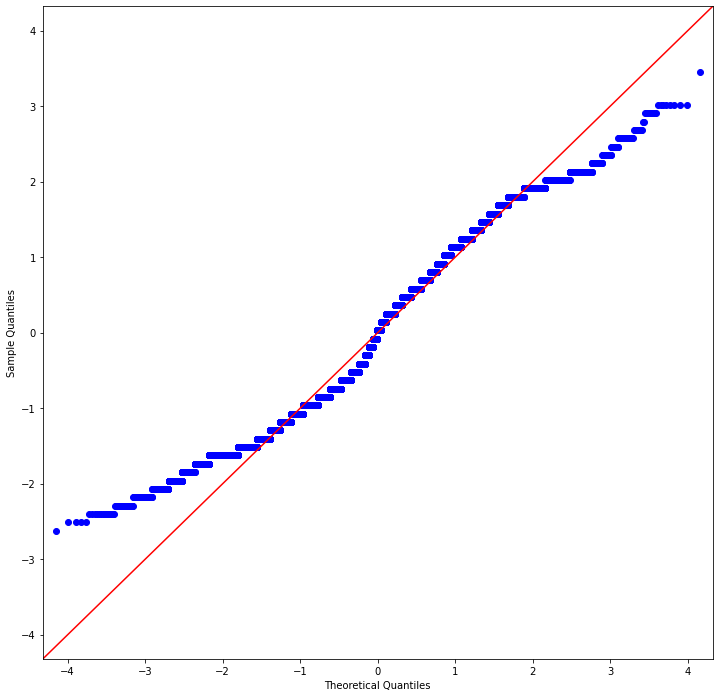

In [30]:
def qq(data):
    plt.rc("figure", figsize=(12,12))
    sm.qqplot(data, 
              fit=True, 
              line="45")
    plt.show()

qq(df_clean["nutrition-score-fr_100g"].dropna())

Visuellement, la distribution des valeurs de ```nutrition-score-fr_100g``` semble à peu près normale.

Faisons un test de Shapiro-Wilk pour nous en assurer.

Le test de Shapiro-Wilk évalue un échantillon de données et quantifie la probabilité que les données aient été tirées d'une distribution gaussienne, du nom de Samuel Shapiro et Martin Wilk
La fonction shapiro() SciPy calculera le Shapiro-Wilk sur un ensemble de données donné. La fonction renvoie à la fois la statistique W calculée par le test et la valeur p.

Nous considèrerons l'hypothèse H0 que la distribution est gaussienne (p > alpha)

In [31]:
def shapiro_test(data, verbose=True):
    stat, p = shapiro(data)
    if(verbose):
        print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpretation
    alpha = 0.05
    if p > alpha:
        if(verbose):
            print("L'échantillon semble Gaussien (échoue à rejeter H0)")
        return True
    else:
        if(verbose):
            print("L'échantillon ne semble pas Gaussien (rejette H0)")
        return False

shapiro_test(df_clean["nutrition-score-fr_100g"].dropna())

Statistics=0.972, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


False

Essayons maintenant avec le test k^2 de D'Agostino.
Le test K^2 de D'Agostino calcule des statistiques récapitulatives à partir des données, à savoir l'aplatissement et l'asymétrie, pour déterminer si la distribution des données s'écarte de la distribution normale, du nom de Ralph D'Agostino.

- **Skew** est une quantification de combien une distribution est poussée à gauche ou à droite, une mesure de l'asymétrie dans la distribution.
- **Kurtosis** quantifie la part de la distribution dans la queue. Il s'agit d'un test statistique de normalité simple et couramment utilisé.

Le test K^2 de D'Agostino est disponible via la fonction SciPy normaltest() et renvoie la statistique du test et la valeur p.

In [32]:
def k2_test(data, verbose=True):
    stat, p = normaltest(data)
    if(verbose):
        print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpretation
    alpha = 0.05
    if p > alpha:
        if(verbose):
            print("L'échantillon semble Gaussien (échoue à rejeter H0)")
        return True
    else:
        if(verbose):
            print("L'échantillon ne semble pas Gaussien (rejette H0)")
        return False
k2_test(df_clean["nutrition-score-fr_100g"].dropna())

Statistics=10502.676, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)


False

Essayons de trouver, parmis les variables quantitatives, lesquels ont une distribution gaussienne:

-------------------------------------
colonne : fat_100g


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


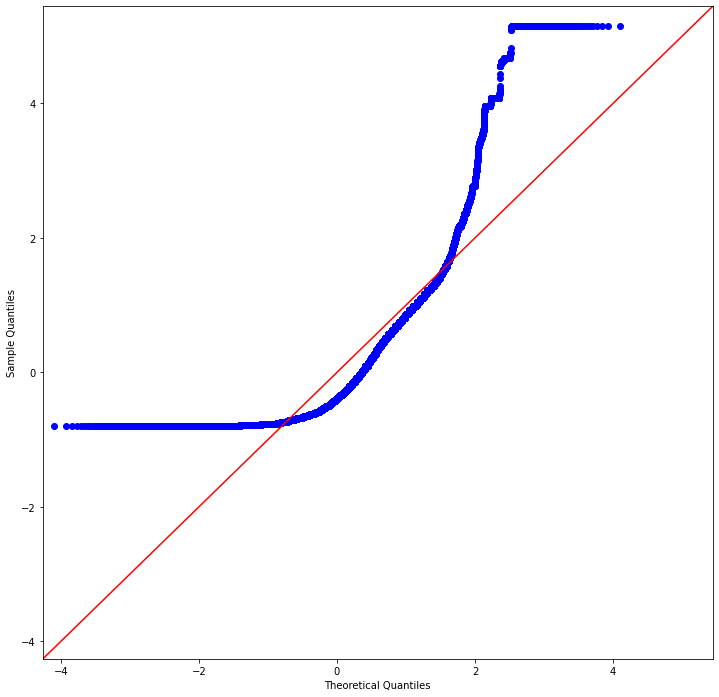

Statistics=0.757, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
Statistics=21963.559, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------
-------------------------------------
colonne : carbohydrates_100g


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


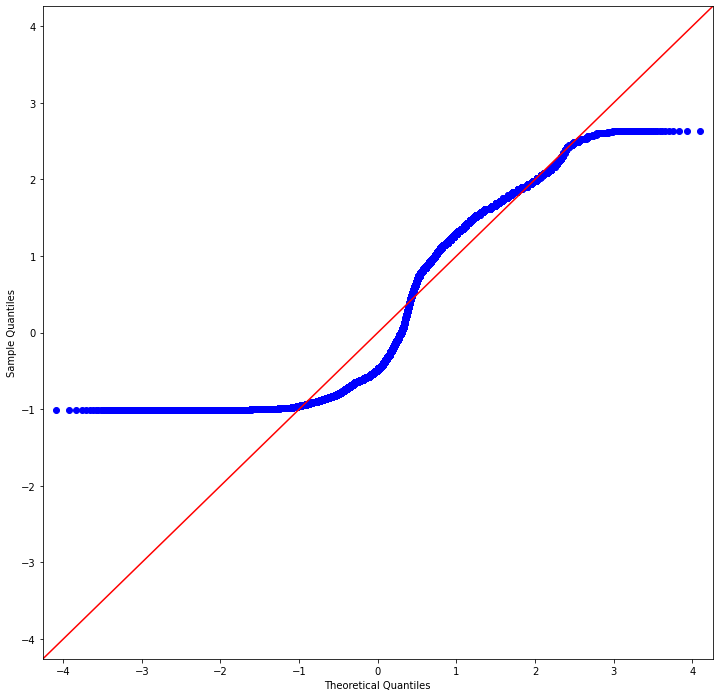

Statistics=0.855, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
Statistics=11208.516, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------
-------------------------------------
colonne : energy_100g
Impossible de tracer le qqplot
Statistics=0.950, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=3587.508, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------
-------------------------------------
colonne : saturated-fat_100g


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


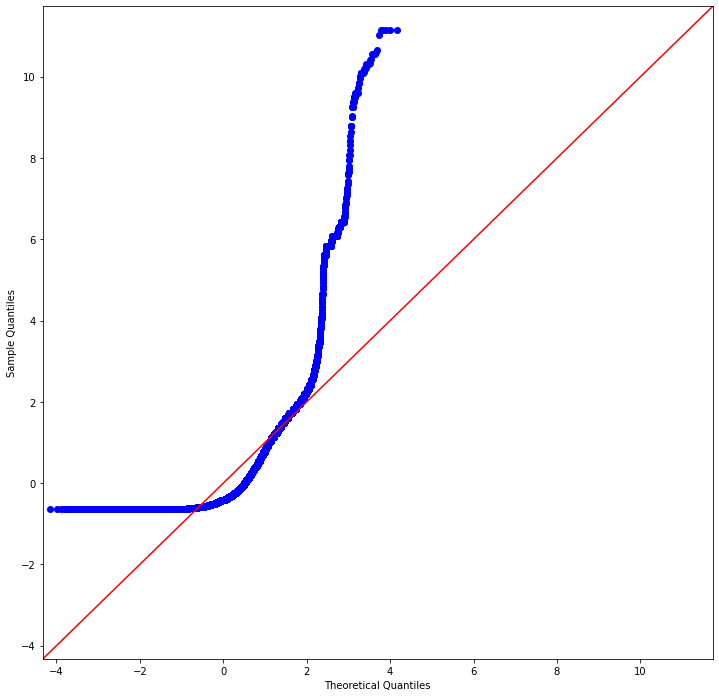

Statistics=0.643, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
Statistics=47681.319, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------
-------------------------------------
colonne : sugars_100g


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


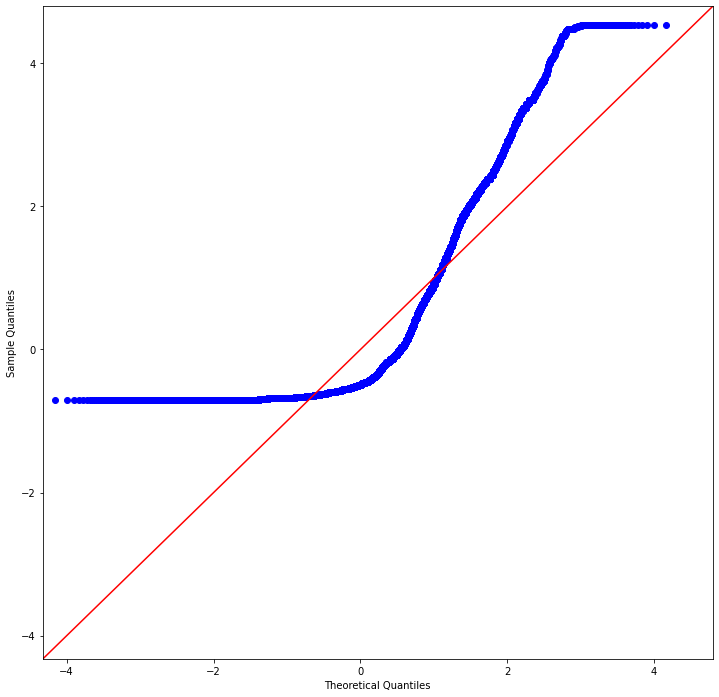

Statistics=0.719, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
Statistics=21864.373, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------
-------------------------------------
colonne : fiber_100g


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


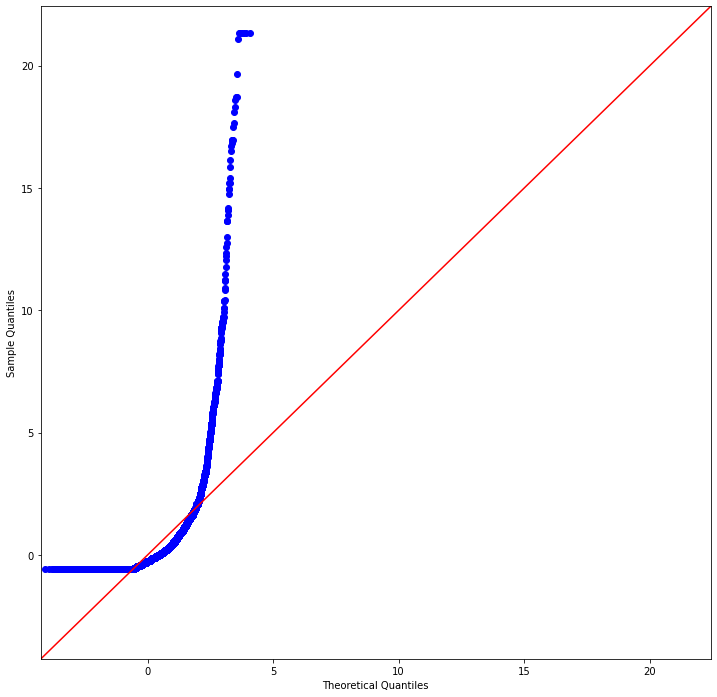

Statistics=0.512, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
Statistics=59911.392, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------
-------------------------------------
colonne : salt_100g


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


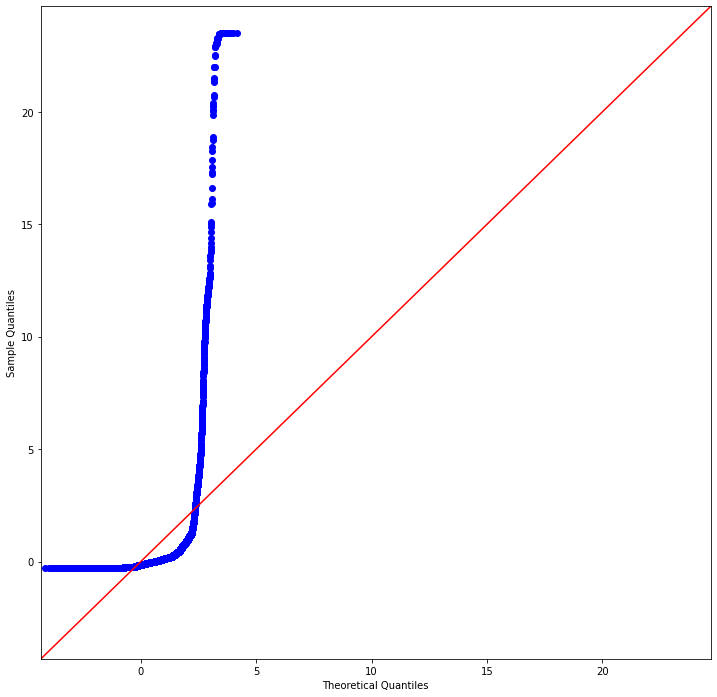

Statistics=0.181, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
Statistics=121044.100, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------
-------------------------------------
colonne : proteins_100g


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


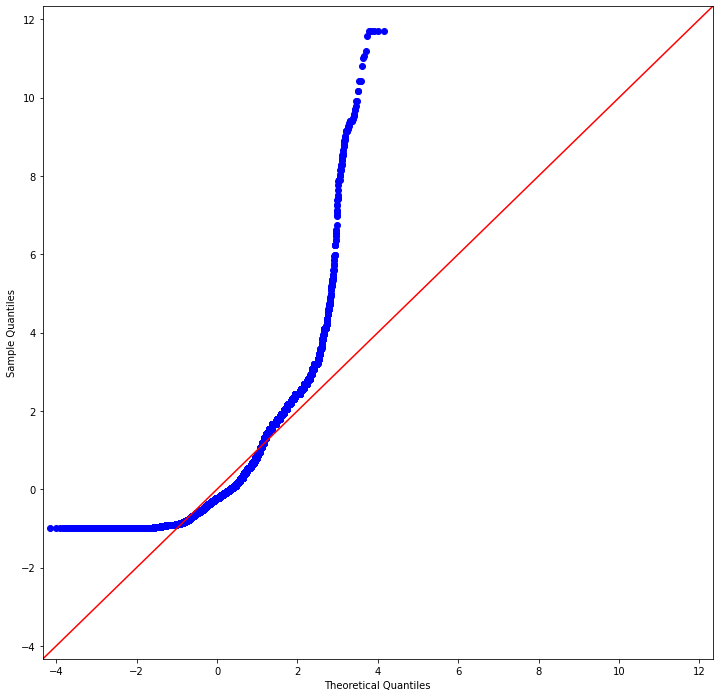

Statistics=0.817, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
Statistics=34082.919, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------
-------------------------------------
colonne : nutrition-score-fr_100g


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


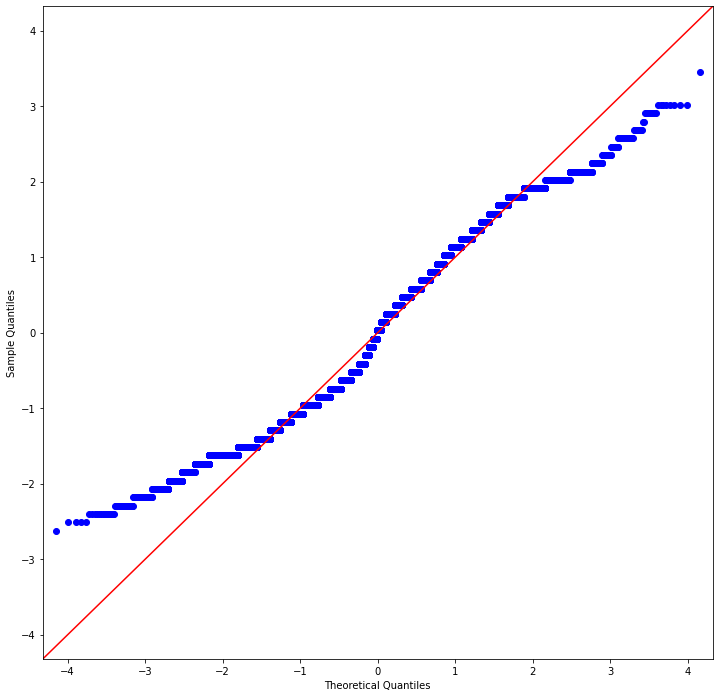

Statistics=0.972, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
Statistics=10502.676, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------
-------------------------------------
colonne : fruits-vegetables-nuts_100g


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


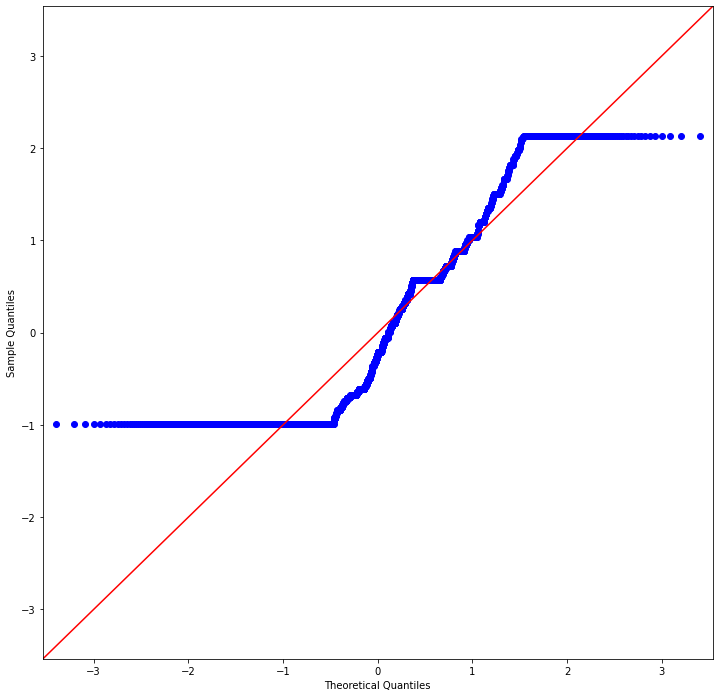

Statistics=0.861, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
Statistics=361.043, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------
-------------------------------------
colonne : vitamin-d_100g


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


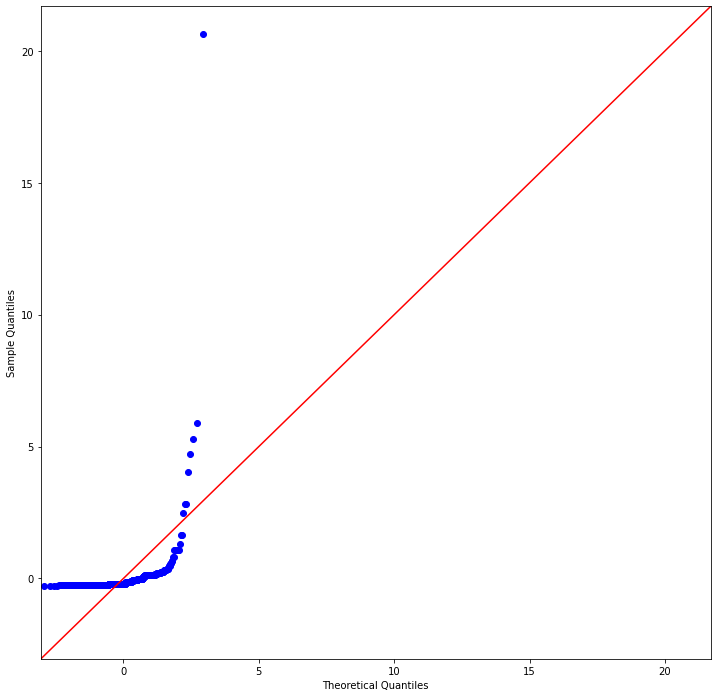

Statistics=0.183, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
Statistics=1240.587, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------
-------------------------------------
colonne : vitamin-c_100g


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


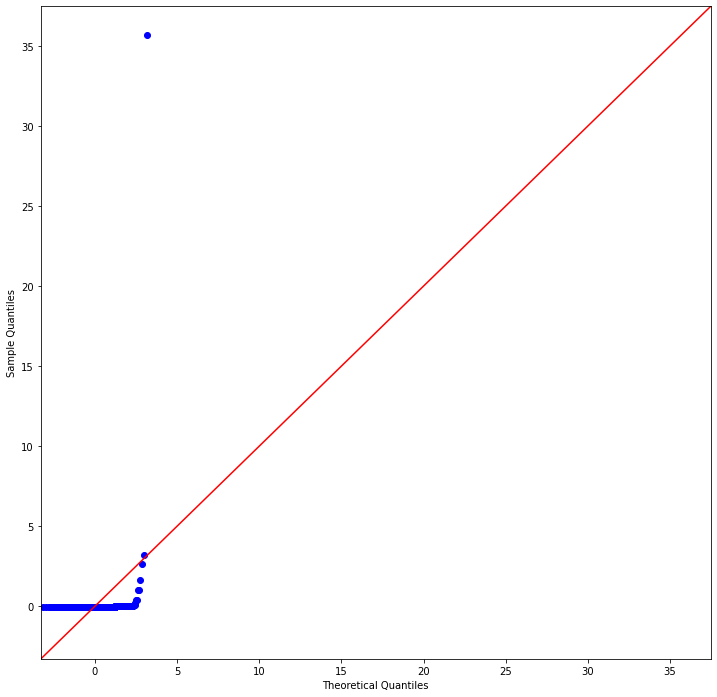

Statistics=0.016, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
Statistics=3668.960, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------
-------------------------------------
colonne : iron_100g


C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


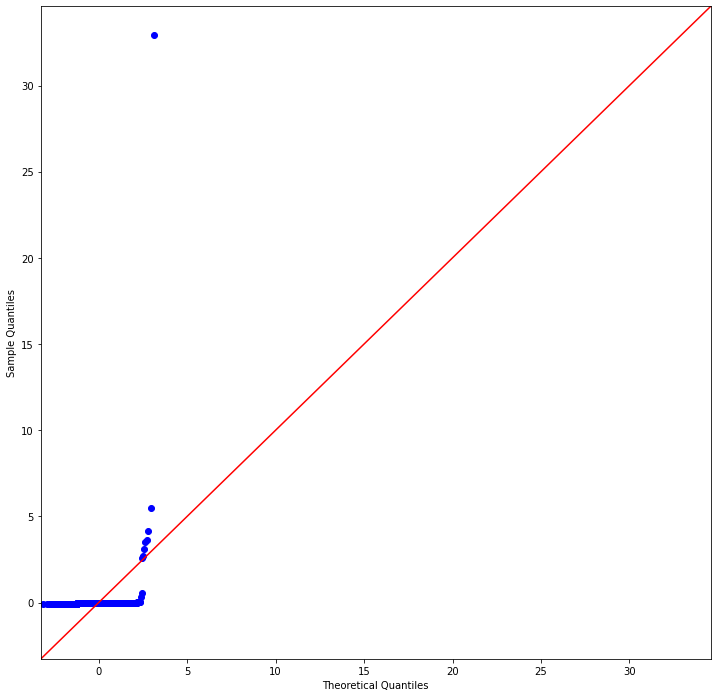

Statistics=0.027, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
Statistics=3183.658, p=0.000
L'échantillon ne semble pas Gaussien (rejette H0)
-------------------------------------


In [33]:
for col_name in ls_nutri_quanti:
    print("-------------------------------------")
    print("colonne : {}".format(col_name))
    col = df_clean[col_name].dropna()
    try:
        qq(col)
    except:
        print("Impossible de tracer le qqplot")
    shapiro_test(col)
    k2_test(col)
    print("-------------------------------------")

In [34]:
df_clean["pnns_groups_1"].unique().tolist()

[nan,
 'Beverages',
 'Sugary snacks',
 'Composite foods',
 'Fruits and vegetables',
 'Milk and dairy products',
 'Fat and sauces',
 'Salty snacks',
 'Cereals and potatoes',
 'Fish Meat Eggs']

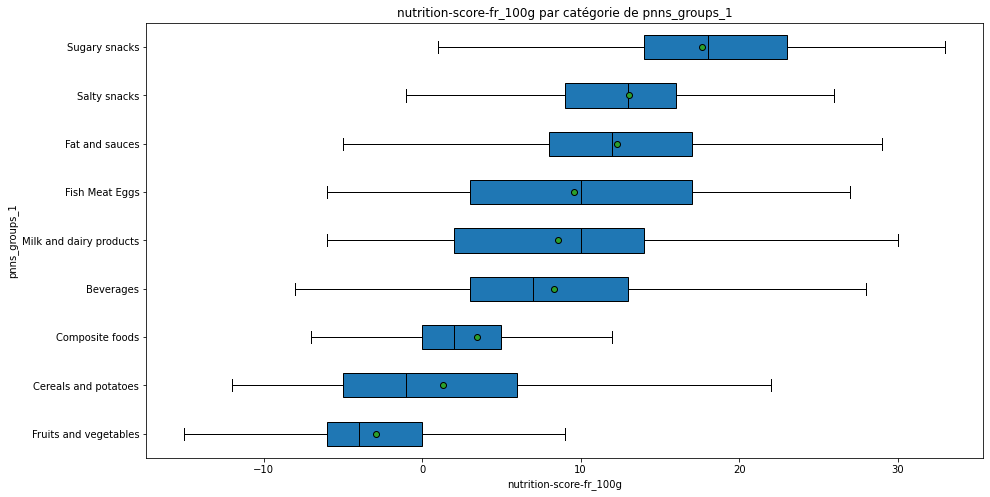

In [35]:
anova_bplot(df_clean, "pnns_groups_1", "nutrition-score-fr_100g")

In [36]:
df2 = df_clean.dropna(subset=["pnns_groups_1", "nutrition-score-fr_100g"])
eta_squared(df2["pnns_groups_1"], df2["nutrition-score-fr_100g"])

0.46499483023619254

In [37]:
for colqual in ls_nutri_quali:
    for colquant in ls_nutri_quanti:
        df_tmp = df_clean.dropna(subset=[colqual, colquant])
        print("ANOVA : influence de {} sur {}".format(colqual, colquant))
        print("eta carré = {}".format(eta_squared(df_tmp[colqual], df_tmp[colquant])))

ANOVA : influence de ingredients_text sur fat_100g
eta carré = 0.9979696948405654
ANOVA : influence de ingredients_text sur carbohydrates_100g
eta carré = 0.999055204339196
ANOVA : influence de ingredients_text sur energy_100g
eta carré = 0.9976466836853098
ANOVA : influence de ingredients_text sur saturated-fat_100g
eta carré = 0.9955758489954243
ANOVA : influence de ingredients_text sur sugars_100g
eta carré = 0.9986002383394285
ANOVA : influence de ingredients_text sur fiber_100g
eta carré = 0.9851576626978168
ANOVA : influence de ingredients_text sur salt_100g
eta carré = 0.9993736478259029
ANOVA : influence de ingredients_text sur proteins_100g
eta carré = 0.9975132724932043
ANOVA : influence de ingredients_text sur nutrition-score-fr_100g
eta carré = 0.9976108524729463
ANOVA : influence de ingredients_text sur fruits-vegetables-nuts_100g
eta carré = 0.9977084345038555
ANOVA : influence de ingredients_text sur vitamin-d_100g
eta carré = 0.9999999999999996
ANOVA : influence de ingr

Pour l'analyse, nous nous séparerons des variables quantitatives fortements corrélées à d'autres, ainsi que de certaines variables quantitatives :

In [38]:
# ls_nutri_quali_keep = ls_nutri_quali.remove("ingredients_text")
ls_nutri_quali_keep = ls_nutri_quali.copy()
ls_nutri_quali_keep.remove("ingredients_text")
ls_quali_keep = ls_nutri_quali_keep.copy() + ["pnns_groups_1"]
ls_quanti_keep = set(ls_nutri_quanti) - set(["saturated-fat_100g","sugars_100g", "vitamin-d_100g", "vitamin-c_100g"])
display(ls_quali_keep, ls_quanti_keep)

['allergens',
 'traces',
 'additives',
 'ingredients_from_palm_oil_n',
 'nutrition_grade_fr',
 'pnns_groups_1']

{'carbohydrates_100g',
 'energy_100g',
 'fat_100g',
 'fiber_100g',
 'fruits-vegetables-nuts_100g',
 'iron_100g',
 'nutrition-score-fr_100g',
 'proteins_100g',
 'salt_100g'}

L'anova nécessitant que les distributions des variables quantitatives soient gaussiennes, nous allons créer une copie du dataframe où nous allons appliquer une transformation box-cox sur les variables quantitatives :

In [39]:
ls_anova_keep = []
ls_anova_keep += ls_quali_keep
ls_anova_keep += ls_quanti_keep


In [40]:
df_for_anova = df_clean[ls_anova_keep].copy()
qt = preprocessing.QuantileTransformer()
for col in ls_quanti_keep:
    print(col)
    df_for_anova[col] = qt.fit_transform(df_for_anova[[col]])

df_for_anova.replace(0, np.nan, inplace=True)

carbohydrates_100g
nutrition-score-fr_100g
fruits-vegetables-nuts_100g
iron_100g
energy_100g
proteins_100g
fiber_100g
salt_100g
fat_100g


In [41]:
df_for_anova[ls_quanti_keep].head()

carbohydrates_100g  nutrition-score-fr_100g  fruits-vegetables-nuts_100g  \
0            0.898899                 0.916917                          NaN   
1            0.954861                      NaN                          NaN   
2                 NaN                 0.689690                          NaN   
3                 NaN                 0.689690                          NaN   
4            0.400901                 0.645646                          NaN   

   iron_100g  energy_100g  proteins_100g  fiber_100g  salt_100g  fat_100g  
0   0.093093     0.823824       0.282783    0.667167   0.264687  0.732733  
1   0.086746     0.659159       0.521021    0.893393        NaN  0.419119  
2        NaN     0.788188       0.145145    0.422422   0.120120       NaN  
3        NaN     0.960460       0.712713    0.796296   0.088088       NaN  
4        NaN     0.086086            NaN         NaN   0.178178       NaN

In [42]:
def normtest_everything(df, ls_quali, ls_quanti):
    qualitative = []
    quantitative = []
    p_shapiro = []
    f_shapiro = []
    is_gaussian_shapiro = []
    p_k2 = []
    f_k2 = []
    is_gaussian_k2 = []
    eta_carres = []
    nb_values = []
    alpha = 0.05
    for colqual in ls_quali:
        for colquant in ls_quanti:
            df_tmp = df.dropna(subset=[colqual, colquant])
            stat_shap, p_shap = shapiro(df_tmp[colquant])
            stat_k2, p_k = normaltest(df_tmp[colquant])
            qualitative.append(colqual)
            quantitative.append(colquant)
            p_shapiro.append(p_shap)
            f_shapiro.append(stat_shap)
            is_gaussian_shapiro.append((p_shap > alpha))
            p_k2.append(p_k)
            f_k2.append(stat_k2)
            is_gaussian_k2.append((p_k > alpha))
            eta_carres.append(eta_squared(df_tmp[colqual], df_tmp[colquant]))
            nb_values.append(df_tmp.shape[0])
            
    df_result = pd.DataFrame({
        "qualitative" : qualitative,
        "quantitative" : quantitative,
        "p_shapiro" : p_shapiro,
        "f_shapiro" : f_shapiro,
        "is_gaussian_shapiro": is_gaussian_shapiro,
        "p_k2" : p_k2,
        "f_k2": f_k2,
        "is_gaussian_k2" : is_gaussian_k2,
        "eta_squared" : eta_carres,
        "nb_values" : nb_values, 
    })
    return df_result

In [43]:
df_normtest = normtest_everything(df_for_anova, ls_quali_keep, ls_quanti_keep)
display(df_normtest)

C:\Users\Utilisateur\anaconda3\envs\OC_P03\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


qualitative                 quantitative     p_shapiro  \
0                     allergens           carbohydrates_100g  0.000000e+00   
1                     allergens      nutrition-score-fr_100g  0.000000e+00   
2                     allergens  fruits-vegetables-nuts_100g  5.120161e-19   
3                     allergens                    iron_100g  1.113466e-11   
4                     allergens                  energy_100g  0.000000e+00   
5                     allergens                proteins_100g  0.000000e+00   
6                     allergens                   fiber_100g  1.261169e-44   
7                     allergens                    salt_100g  0.000000e+00   
8                     allergens                     fat_100g  0.000000e+00   
9                        traces           carbohydrates_100g  0.000000e+00   
10                       traces      nutrition-score-fr_100g  0.000000e+00   
11                       traces  fruits-vegetables-nuts_100g  2.244190e-10   
12                       traces                    iron_100g  9.818474e-10   
13                       traces                  energy_100g  0.000000e+00   
14                       traces                proteins_100g  8.448222e-38   
15                       traces                   fiber_100g  0.000000e+00   
16                       traces                    salt_100g  0.000000e+00   
17                       traces                     fat_100g  0.000000e+00   
18                    additives           carbohydrates_100g  0.000000e+00   
19                    additives      nutrition-score-fr_100g  0.000000e+00   
20                    additives  fruits-vegetables-nuts_100g  5.587936e-24   
21                    additives                    iron_100g  3.106576e-17   
22                    additives                  energy_100g  0.000000e+00   
23                    additives                proteins_100g  0.000000e+00   
24                    additives                   fiber_100g  0.000000e+00   
25                    additives                    salt_100g  0.000000e+00   
26                    additives                     fat_100g  0.000000e+00   
27  ingredients_from_palm_oil_n           carbohydrates_100g  0.000000e+00   
28  ingredients_from_palm_oil_n      nutrition-score-fr_100g  1.954251e-41   
29  ingredients_from_palm_oil_n  fruits-vegetables-nuts_100g  1.631133e-02   
30  ingredients_from_palm_oil_n                    iron_100g  6.027356e-06   
31  ingredients_from_palm_oil_n                  energy_100g  0.000000e+00   
32  ingredients_from_palm_oil_n                proteins_100g  1.575477e-10   
33  ingredients_from_palm_oil_n                   fiber_100g  5.818805e-23   
34  ingredients_from_palm_oil_n                    salt_100g  2.816737e-23   
35  ingredients_from_palm_oil_n                     fat_100g  5.343175e-33   
36           nutrition_grade_fr           carbohydrates_100g  0.000000e+00   
37           nutrition_grade_fr      nutrition-score-fr_100g  0.000000e+00   
38           nutrition_grade_fr  fruits-vegetables-nuts_100g  2.935961e-24   
39           nutrition_grade_fr                    iron_100g  1.836207e-17   
40           nutrition_grade_fr                  energy_100g  0.000000e+00   
41           nutrition_grade_fr                proteins_100g  0.000000e+00   
42           nutrition_grade_fr                   fiber_100g  0.000000e+00   
43           nutrition_grade_fr                    salt_100g  0.000000e+00   
44           nutrition_grade_fr                     fat_100g  0.000000e+00   
45                pnns_groups_1           carbohydrates_100g  0.000000e+00   
46                pnns_groups_1      nutrition-score-fr_100g  0.000000e+00   
47                pnns_groups_1  fruits-vegetables-nuts_100g  1.630143e-23   
48                pnns_groups_1                    iron_100g  7.147705e-14   
49                pnns_groups_1                  energy_100g  0.000000e+00   
50                pnns_groups_1           

In [65]:
df_normtest.loc[df_normtest["qualitative"]=="nutrition_grade_fr"].sort_values(by="eta_squared", ascending=False)

qualitative                 quantitative     p_shapiro  f_shapiro  \
37  nutrition_grade_fr      nutrition-score-fr_100g  0.000000e+00   0.953923   
44  nutrition_grade_fr                     fat_100g  0.000000e+00   0.955306   
40  nutrition_grade_fr                  energy_100g  0.000000e+00   0.954667   
39  nutrition_grade_fr                    iron_100g  1.836207e-17   0.953930   
38  nutrition_grade_fr  fruits-vegetables-nuts_100g  2.935961e-24   0.950185   
43  nutrition_grade_fr                    salt_100g  0.000000e+00   0.954297   
42  nutrition_grade_fr                   fiber_100g  0.000000e+00   0.955034   
36  nutrition_grade_fr           carbohydrates_100g  0.000000e+00   0.955231   
41  nutrition_grade_fr                proteins_100g  0.000000e+00   0.955544   

    is_gaussian_shapiro           p_k2          f_k2  is_gaussian_k2  \
37                False   0.000000e+00  54386.311327           False   
44                False   0.000000e+00  33039.963020           False   
40                False   0.000000e+00  55487.012577           False   
39                False  8.407803e-160    732.568909           False   
38                False  1.462197e-212    975.536199           False   
43                False   0.000000e+00  49984.636090           False   
42                False   0.000000e+00  25745.191602           False   
36                False   0.000000e+00  36188.651334           False   
41                False   0.000000e+00  47042.973970           False   

    eta_squared  nb_values  
37     0.930378      61113  
44     0.413170      40689  
40     0.315235      60629  
39     0.117243       1031  
38     0.114667       1801  
43     0.099466      56072  
42     0.054523      31252  
36     0.030147      42324  
41     0.026472      57786

[Text(0.5, 0, 'variable nutritionnelle quantitative'),
 Text(0, 0.5, 'Eta carré')]

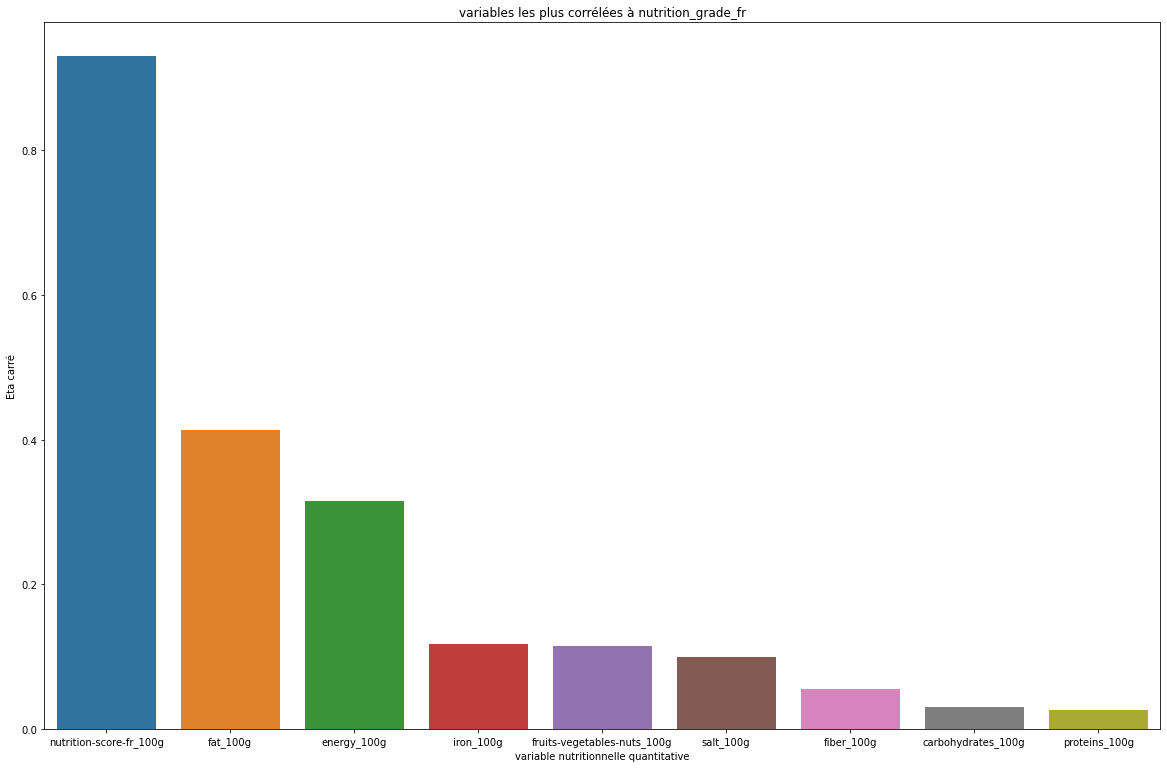

In [73]:
df_anova_graph = df_normtest.loc[df_normtest["qualitative"]=="nutrition_grade_fr"].sort_values(by="eta_squared", ascending=False)
fig, ax = plt.subplots(figsize=(20,13))
ax.set_title("variables les plus corrélées à nutrition_grade_fr")
sns.barplot(x="quantitative", 
            y="eta_squared", 
            data=df_anova_graph).set(
                xlabel='variable nutritionnelle quantitative', 
                ylabel='Eta carré',
                
            )

[Text(0.5, 0, 'variable nutritionnelle quantitative'),
 Text(0, 0.5, 'Eta carré')]

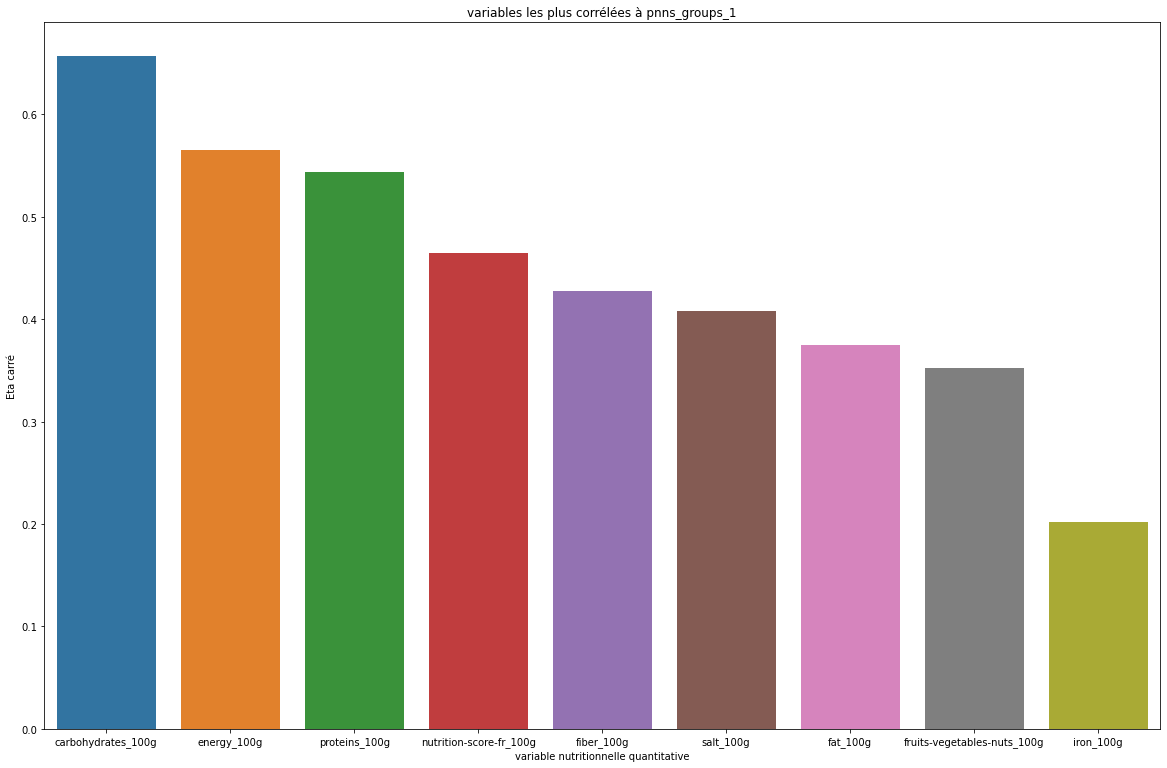

In [74]:
df_anova_graph = df_normtest.loc[df_normtest["qualitative"]=="pnns_groups_1"].sort_values(by="eta_squared", ascending=False)
fig, ax = plt.subplots(figsize=(20,13))
ax.set_title("variables les plus corrélées à pnns_groups_1")
sns.barplot(x="quantitative", 
            y="eta_squared", 
            data=df_anova_graph).set(
                xlabel='variable nutritionnelle quantitative', 
                ylabel='Eta carré',
                
            )

In [44]:
df_normtest.to_csv("df_normtest.csv")

In [54]:
def anova_everything(df, ls_quali, ls_quanti):
    qualitative = []
    quantitative = []
    f_anova = []
    p_anova = []
    sum_sq = []
    is_significant = []
    alpha = 0.05
    for colqual in ls_quali:
        for colquant in ls_quanti:
            df_tmp = df.dropna(subset=[colqual, colquant])
            model = smf.ols("Q('{}') ~ Q('{}')".format(colquant, colqual), data=df_tmp).fit()
            table = sm.stats.anova_lm(model, typ=2)
            f_anova.append(table["F"][0])
            p_anova.append(table["PR(>F)"][0])
            sum_sq.append(table["sum_sq"][0])
            is_significant.append((table["PR(>F)"][0] > alpha))
    df_result = pd.DataFrame({
        "qualitative" : qualitative,
        "quantitative" : quantitative,
        "f_anova": f_anova,
        "p_anova": p_anova,
        "sum_sq": sum_sq,
        "is_significant": is_significant
    })
    return df_result

In [55]:
# df_anova = anova_everything(df_for_anova, ls_quali_keep, ls_quanti_keep)

LinAlgError: SVD did not converge

In [56]:
quan = "nutrition-score-fr_100g"
qual = "pnns_groups_1"
# model = statsmodels.formula.api.ols("Q('nutrition-score-fr_100g') ~ Q('nutrition_grade_fr')", data=df_tst).fit()
model = smf.ols("Q('{}') ~ Q('{}')".format(quan, qual), data=df_tst).fit()
table = statsmodels.api.stats.anova_lm(model, typ=2)
table

AttributeError: module 'statsmodels.api' has no attribute 'anova_lm'

##### 